In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime
import os

In [2]:
# display options
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Load all sheets
df_orders = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Order_Details')
df_customers = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Customers')
df_products = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Products')
df_suppliers = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Suppliers')
df_inventory = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Inventory')
df_labor = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Labor')
df_shipping = pd.read_excel(r"C:\Users\USER\Desktop\New folder\Dataset for my Portfolio\For real datasets\Modest Apparel\New\Nigerian_Fashion_Retail_Datasetv1.xlsx", sheet_name='Shipping_Details')

# REVENUE, ORDERS, AND AOV

## KPIs

#### CREATE CALCULATED FIELDS IN ORDER DETAILS

In [4]:
# check order details
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42077 entries, 0 to 42076
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Order_ID            42077 non-null  object        
 1   Product_Name        42077 non-null  object        
 2   Quantity            42077 non-null  int64         
 3   Customer            42077 non-null  object        
 4   Order_Datetime      42077 non-null  datetime64[ns]
 5   Order_Mode          42077 non-null  object        
 6   Price_Per_Quantity  42077 non-null  float64       
 7   Discount_Applied    42077 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.6+ MB


In [5]:

df_orders.head()

,Order_ID,Product_Name,Quantity,Customer,Order_Datetime,Order_Mode,Price_Per_Quantity,Discount_Applied
0,ORD_000001,Denim Jeans,2,C_072,2024-05-14 16:25:00,online,"11,500.00",0.00
1,ORD_000001,Damask Fabric (4 yards),3,C_072,2024-05-14 16:25:00,online,"31,000.00",0.00
2,ORD_000002,Coral Beaded Necklace,4,C_088,2024-05-12 23:43:00,online,"15,000.00",0.00
3,ORD_000002,Beaded Shawl,1,C_088,2024-05-12 23:43:00,online,"11,000.00",0.00
4,ORD_000002,Ankara Shorts,3,C_088,2024-05-12 23:43:00,online,"5,500.00",0.00


In [6]:
# Convert datetime
df_orders['Order_Datetime'] = pd.to_datetime(df_orders['Order_Datetime'])

In [7]:
# Extract time components
df_orders['Year'] = df_orders['Order_Datetime'].dt.year
df_orders['Month'] = df_orders['Order_Datetime'].dt.month
df_orders['Month_Name'] = df_orders['Order_Datetime'].dt.strftime('%B')
df_orders['Week'] = df_orders['Order_Datetime'].dt.isocalendar().week
df_orders['Day'] = df_orders['Order_Datetime'].dt.day
df_orders['DayOfWeek'] = df_orders['Order_Datetime'].dt.day_name()
df_orders['Hour'] = df_orders['Order_Datetime'].dt.hour
df_orders['Date'] = df_orders['Order_Datetime'].dt.date
df_orders.head()

,Order_ID,Product_Name,Quantity,Customer,Order_Datetime,Order_Mode,Price_Per_Quantity,Discount_Applied,Year,Month,Month_Name,Week,Day,DayOfWeek,Hour,Date
0,ORD_000001,Denim Jeans,2,C_072,2024-05-14 16:25:00,online,"11,500.00",0.00,2024,5,May,20,14,Tuesday,16,2024-05-14
1,ORD_000001,Damask Fabric (4 yards),3,C_072,2024-05-14 16:25:00,online,"31,000.00",0.00,2024,5,May,20,14,Tuesday,16,2024-05-14
2,ORD_000002,Coral Beaded Necklace,4,C_088,2024-05-12 23:43:00,online,"15,000.00",0.00,2024,5,May,19,12,Sunday,23,2024-05-12
3,ORD_000002,Beaded Shawl,1,C_088,2024-05-12 23:43:00,online,"11,000.00",0.00,2024,5,May,19,12,Sunday,23,2024-05-12
4,ORD_000002,Ankara Shorts,3,C_088,2024-05-12 23:43:00,online,"5,500.00",0.00,2024,5,May,19,12,Sunday,23,2024-05-12


In [8]:
# Calculate Revenue fields
df_orders['Line_Revenue'] = df_orders['Price_Per_Quantity'] * df_orders['Quantity']
df_orders['Discount_Amount'] = df_orders['Line_Revenue'] * df_orders['Discount_Applied']
df_orders['Net_Revenue'] = df_orders['Line_Revenue'] - df_orders['Discount_Amount']

In [9]:
# Period classification
def classify_period(month):
    if month <= 8:
        return 'Pre-Crisis'
    elif month <= 11:
        return 'Crisis'
    else:
        return 'Holiday'

df_orders['Period'] = df_orders['Month'].apply(classify_period)

In [10]:
# Weekend flag
df_orders['Is_Weekend'] = df_orders['DayOfWeek'].isin(['Friday', 'Saturday', 'Sunday'])

#### MERGE WITH PRODUCT AND CUSTOMER DATA

In [11]:
# Merge with Products
df_orders_enriched = df_orders.merge(
    df_products[['Product_Name', 'Category', 'Cost', 'Supplier_ID']],
    on='Product_Name',
    how='left'
)

In [12]:
# Merge with Customers
df_orders_enriched = df_orders_enriched.merge(
    df_customers[['Customer_ID', 'Customer_Name', 'Location', 'Gender']],
    left_on='Customer',
    right_on='Customer_ID',
    how='left'
)

In [13]:
# Calculate profit
df_orders_enriched['Unit_Profit'] = df_orders_enriched['Price_Per_Quantity'] - df_orders_enriched['Cost']
df_orders_enriched['Line_Profit'] = df_orders_enriched['Unit_Profit'] * df_orders_enriched['Quantity']
df_orders_enriched.head()

,Order_ID,Product_Name,Quantity,Customer,Order_Datetime,Order_Mode,Price_Per_Quantity,Discount_Applied,Year,Month,...,Is_Weekend,Category,Cost,Supplier_ID,Customer_ID,Customer_Name,Location,Gender,Unit_Profit,Line_Profit
0,ORD_000001,Denim Jeans,2,C_072,2024-05-14 16:25:00,online,"11,500.00",0.00,2024,5,...,False,Modern,5500,S_015,C_072,Deborah Johnson,Rivers,Female,"6,000.00","12,000.00"
1,ORD_000001,Damask Fabric (4 yards),3,C_072,2024-05-14 16:25:00,online,"31,000.00",0.00,2024,5,...,False,Traditional,16000,S_009,C_072,Deborah Johnson,Rivers,Female,"15,000.00","45,000.00"
2,ORD_000002,Coral Beaded Necklace,4,C_088,2024-05-12 23:43:00,online,"15,000.00",0.00,2024,5,...,True,Traditional,8000,S_019,C_088,Faith Ajayi,Ogun,Female,"7,000.00","28,000.00"
3,ORD_000002,Beaded Shawl,1,C_088,2024-05-12 23:43:00,online,"11,000.00",0.00,2024,5,...,True,Traditional,5500,S_015,C_088,Faith Ajayi,Ogun,Female,"5,500.00","5,500.00"
4,ORD_000002,Ankara Shorts,3,C_088,2024-05-12 23:43:00,online,"5,500.00",0.00,2024,5,...,True,Traditional,2500,S_002,C_088,Faith Ajayi,Ogun,Female,"3,000.00","9,000.00"


#### CREATE MONTHLY KPI SUMMARY

In [14]:
# Aggregate by month

monthly_kpis = (df_orders_enriched.groupby(['Month', 'Month_Name'], as_index=False)
    .agg({
        'Order_ID': 'nunique',
        'Net_Revenue': 'sum',
        'Line_Revenue': 'sum',
        'Discount_Amount': 'sum',
        'Line_Profit': 'sum',
        'Quantity': 'sum'
    })
    .sort_values('Month')
)
monthly_kpis.head(10)

,Month,Month_Name,Order_ID,Net_Revenue,Line_Revenue,Discount_Amount,Line_Profit,Quantity
0,5,May,775,"246,734,500.00","246,734,500.00",0.00,"120,468,000.00",16072
1,6,June,805,"262,848,500.00","262,848,500.00",0.00,"128,373,000.00",17057
2,7,July,750,"241,141,500.00","241,141,500.00",0.00,"117,818,500.00",15717
3,8,August,720,"209,545,000.00","209,545,000.00",0.00,"102,478,100.00",13799
4,9,September,665,"288,074,535.90","288,074,535.90",0.00,"162,743,135.90",16001
5,10,October,582,"201,582,123.74","201,582,123.74",0.00,"113,936,423.74",11287
6,11,November,496,"198,404,580.63","200,677,825.08","2,273,244.45","113,245,925.08",11066
7,12,December,469,"178,846,116.45","181,418,676.48","2,572,560.03","102,433,676.48",10017


In [15]:
# Rename columns
monthly_kpis.columns = ['Month', 'Month_Name', 'Order_Count', 'Net_Revenue', 'Gross_Revenue', 
                        'Total_Discounts', 'Total_Profit', 'Units_Sold']


In [16]:
# Calculate AOV
monthly_kpis['AOV'] = monthly_kpis['Net_Revenue'] / monthly_kpis['Order_Count']

In [17]:
# Calculate MoM% changes
monthly_kpis['Revenue_MoM_Pct'] = monthly_kpis['Net_Revenue'].pct_change() * 100
monthly_kpis['Orders_MoM_Pct'] = monthly_kpis['Order_Count'].pct_change() * 100
monthly_kpis['AOV_MoM_Pct'] = monthly_kpis['AOV'].pct_change() * 100
monthly_kpis

,Month,Month_Name,Order_Count,Net_Revenue,Gross_Revenue,Total_Discounts,Total_Profit,Units_Sold,AOV,Revenue_MoM_Pct,Orders_MoM_Pct,AOV_MoM_Pct
0,5,May,775,"246,734,500.00","246,734,500.00",0.00,"120,468,000.00",16072,"318,367.10",NaN,NaN,NaN
1,6,June,805,"262,848,500.00","262,848,500.00",0.00,"128,373,000.00",17057,"326,519.88",6.53,3.87,2.56
2,7,July,750,"241,141,500.00","241,141,500.00",0.00,"117,818,500.00",15717,"321,522.00",-8.26,-6.83,-1.53
3,8,August,720,"209,545,000.00","209,545,000.00",0.00,"102,478,100.00",13799,"291,034.72",-13.10,-4.00,-9.48
4,9,September,665,"288,074,535.90","288,074,535.90",0.00,"162,743,135.90",16001,"433,194.79",37.48,-7.64,48.85
5,10,October,582,"201,582,123.74","201,582,123.74",0.00,"113,936,423.74",11287,"346,361.04",-30.02,-12.48,-20.04
6,11,November,496,"198,404,580.63","200,677,825.08","2,273,244.45","113,245,925.08",11066,"400,009.24",-1.58,-14.78,15.49
7,12,December,469,"178,846,116.45","181,418,676.48","2,572,560.03","102,433,676.48",10017,"381,335.00",-9.86,-5.44,-4.67


In [18]:
monthly_kpis_ = monthly_kpis[['Month_Name', 'Order_Count', 'Net_Revenue', 'AOV', 
                     'Orders_MoM_Pct', 'Revenue_MoM_Pct', 'AOV_MoM_Pct']]
monthly_kpis_

,Month_Name,Order_Count,Net_Revenue,AOV,Orders_MoM_Pct,Revenue_MoM_Pct,AOV_MoM_Pct
0,May,775,"246,734,500.00","318,367.10",NaN,NaN,NaN
1,June,805,"262,848,500.00","326,519.88",3.87,6.53,2.56
2,July,750,"241,141,500.00","321,522.00",-6.83,-8.26,-1.53
3,August,720,"209,545,000.00","291,034.72",-4.00,-13.10,-9.48
4,September,665,"288,074,535.90","433,194.79",-7.64,37.48,48.85
5,October,582,"201,582,123.74","346,361.04",-12.48,-30.02,-20.04
6,November,496,"198,404,580.63","400,009.24",-14.78,-1.58,15.49
7,December,469,"178,846,116.45","381,335.00",-5.44,-9.86,-4.67


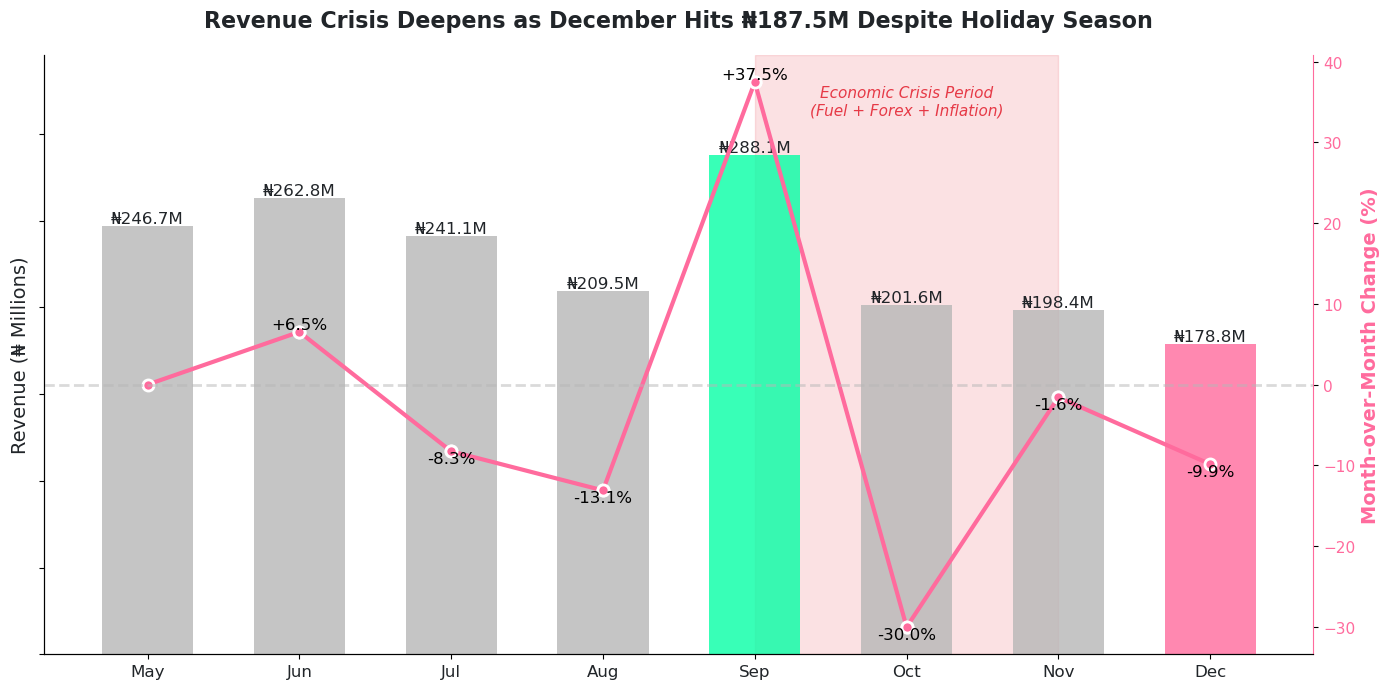

In [19]:
# Color scheme for visualizations
COLORS = {
    'negative': '#E63946',      # Red for decline/negative
    'negative_light': '#FF6B9D', # Pink for moderate negative
    'positive': '#06FFA5',      # Lime green for growth/positive
    'positive_dark': '#06D6A0',  # Darker green
    'neutral': '#b7b7b7',       # Gray for neutral/stable #6C757D
    'traditional': '#FCA311',   # Gold for Traditional category
    'modern': '#4361EE',        # Blue for Modern category
    'cosmetics': '#9D4EDD',     # Purple for Cosmetics
    'accessories': '#F77F00',   # Orange for Accessories
    'background': '#FFFFFF',    # Light gray background
    'text': '#212529'           # Dark text
}



# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor(COLORS['background'])
ax1.set_facecolor(COLORS['background'])

# Plot revenue bars
months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(months))

# Find highest and lowest revenue
max_revenue_idx = monthly_kpis_['Net_Revenue'].idxmax()
min_revenue_idx = monthly_kpis_['Net_Revenue'].idxmin()

# Color bars - neutral for all except highest (green) and lowest (red)
colors = []
for idx, row in monthly_kpis_.iterrows():
    if idx == max_revenue_idx:
        colors.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_revenue_idx:
        colors.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors.append(COLORS['neutral'])  # Neutral gray for others

bars = ax1.bar(x, monthly_kpis_['Net_Revenue'] / 1_000_000, color=colors, alpha=0.8, width=0.6,
               edgecolor='none', linewidth=1.5)

# Add revenue values on bars
for idx, (bar, revenue) in enumerate(zip(bars, monthly_kpis_['Net_Revenue'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'₦{revenue/1_000_000:.1f}M',
             ha='center', va='bottom', fontsize=12, fontweight='normal',
             color=COLORS['text'])

# Configure primary y-axis (Revenue) - Add extra space at top
max_revenue = monthly_kpis_['Net_Revenue'].max() / 1_000_000
ax1.set_ylim(0, max_revenue * 1.2)  # Add 20% extra space at top

ax1.set_ylabel('Revenue (₦ Millions)', fontsize=14, fontweight='normal', color=COLORS['text'])
ax1.set_xlabel('')
ax1.set_xticks(x)
ax1.set_xticklabels(months, fontsize=12)
ax1.set_yticklabels([])
ax1.tick_params(axis='y', labelcolor=COLORS['text'], labelsize=11)
ax1.tick_params(axis='x', labelcolor=COLORS['text'])
ax1.grid('')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)



# Create secondary y-axis for MoM%
ax2 = ax1.twinx()

# Plot MoM% line (skip first month which has NaN)
mom_pct = monthly_kpis_['Revenue_MoM_Pct'].fillna(0)

# Plot line segments in red-pink color
for i in range(1, len(x)):
    ax2.plot([x[i-1], x[i]], [mom_pct[i-1], mom_pct[i]], 
             color=COLORS['negative_light'], linewidth=3, marker='o', markersize=8,
             markeredgecolor='white', markeredgewidth=2)

# Add MoM% labels in black with no background
for idx in range(1, len(monthly_kpis_)):
    val = mom_pct[idx]
    ax2.text(x[idx], val, f'{val:+.1f}%', 
             ha='center', va='bottom' if val >= 0 else 'top',
             fontsize=12, fontweight='normal', color='black')

# Configure secondary y-axis in red-pink color
ax2.set_ylabel('Month-over-Month Change (%)', fontsize=14, fontweight='bold', color=COLORS['negative_light'])
ax2.tick_params(axis='y', labelcolor=COLORS['negative_light'], labelsize=11)
ax2.axhline(y=0, color=COLORS['neutral'], linestyle='--', linewidth=2, alpha=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color(COLORS['negative_light'])

# Title
plt.title('Revenue Crisis Deepens as December Hits ₦187.5M Despite Holiday Season',
          fontsize=16, fontweight='bold', pad=20, color=COLORS['text'])

# Add crisis annotation (no black edge)
ax1.axvspan(4, 6, alpha=0.15, color=COLORS['negative'], zorder=0)
ax1.text(5, ax1.get_ylim()[1] * 0.9, 'Economic Crisis Period\n(Fuel + Forex + Inflation)',
         ha='center', fontsize=11, style='italic', color=COLORS['negative'])


plt.tight_layout()

plt.show()

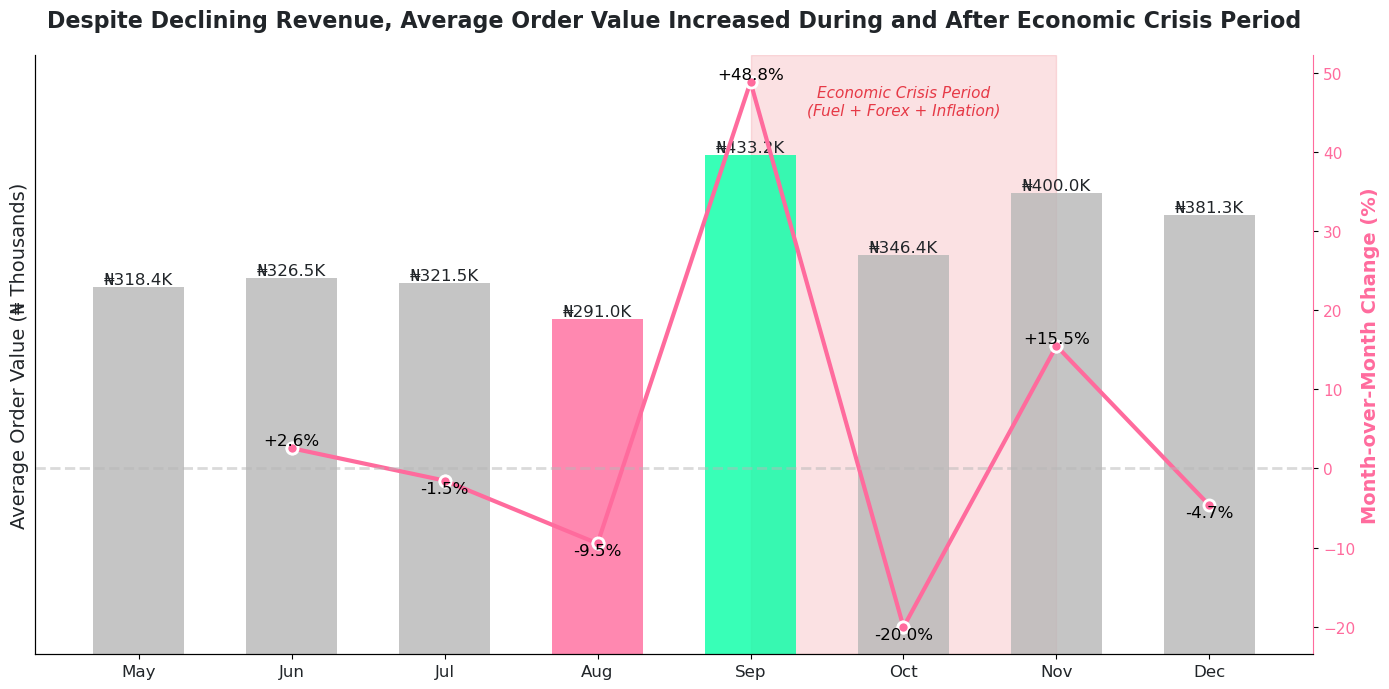

In [20]:

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor(COLORS['background'])
ax1.set_facecolor(COLORS['background'])

months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(months))

# Find highest and lowest AOV
max_aov_idx = monthly_kpis_['AOV'].idxmax()
min_aov_idx = monthly_kpis_['AOV'].idxmin()

# Bar colors
colors = []
for idx in monthly_kpis_.index:
    if idx == max_aov_idx:
        colors.append(COLORS['positive'])
    elif idx == min_aov_idx:
        colors.append(COLORS['negative_light'])
    else:
        colors.append(COLORS['neutral'])

# Plot AOV in ₦ thousands
aov_k = monthly_kpis_['AOV'] / 1_000
bars = ax1.bar(x, aov_k, color=colors, alpha=0.8, width=0.6,
               edgecolor='none', linewidth=0)

# Add value labels on bars (₦K)
for bar, aov in zip(bars, monthly_kpis_['AOV']):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'₦{aov/1_000:,.1f}K',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='normal',
        color=COLORS['text']
    )

# Y limit (match bar units: thousands)
max_aov_k = aov_k.max()
ax1.set_ylim(0, max_aov_k * 1.2)

# Labels + ticks
ax1.set_ylabel('Average Order Value (₦ Thousands)', fontsize=14, fontweight='normal', color=COLORS['text'])
ax1.set_xlabel('')
ax1.set_xticks(x)
ax1.set_xticklabels(months, fontsize=12, color=COLORS['text'])

# Remove y-axis numbers safely (DON’T use set_yticklabels([]))
ax1.set_yticks([])  # removes tick marks and labels

# Styling
ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='x', labelcolor=COLORS['text'])

# Secondary y-axis for MoM%
ax2 = ax1.twinx()
mom_pct_aov = monthly_kpis_['AOV_MoM_Pct'].to_numpy()

# Plot line segments
for i in range(1, len(x)):
    ax2.plot(
        [x[i-1], x[i]],
        [mom_pct_aov[i-1], mom_pct_aov[i]],
        color=COLORS['negative_light'],
        linewidth=3,
        marker='o',
        markersize=8,
        markeredgecolor='white',
        markeredgewidth=2
    )

# Add MoM labels
for i in range(1, len(x)):
    val = mom_pct_aov[i]
    ax2.text(
        x[i],
        val,
        f'{val:+.1f}%',
        ha='center',
        va='bottom' if val >= 0 else 'top',
        fontsize=12,
        fontweight='normal',
        color='black'
    )

ax2.set_ylabel('Month-over-Month Change (%)', fontsize=14, fontweight='bold', color=COLORS['negative_light'])
ax2.tick_params(axis='y', labelcolor=COLORS['negative_light'], labelsize=11)
ax2.axhline(y=0, color=COLORS['neutral'], linestyle='--', linewidth=2, alpha=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color(COLORS['negative_light'])

# Title
ax1.set_title(
    'Despite Declining Revenue, Average Order Value Increased During and After Economic Crisis Period',
    fontsize=16,
    fontweight='bold',
    pad=20,
    color=COLORS['text']
)

# Crisis annotation
ax1.axvspan(4, 6, alpha=0.15, color=COLORS['negative'], zorder=0)
ax1.text(
    5,
    ax1.get_ylim()[1] * 0.9,
    'Economic Crisis Period\n(Fuel + Forex + Inflation)',
    ha='center',
    fontsize=11,
    style='italic',
    color=COLORS['negative']
)

plt.tight_layout()
plt.show()


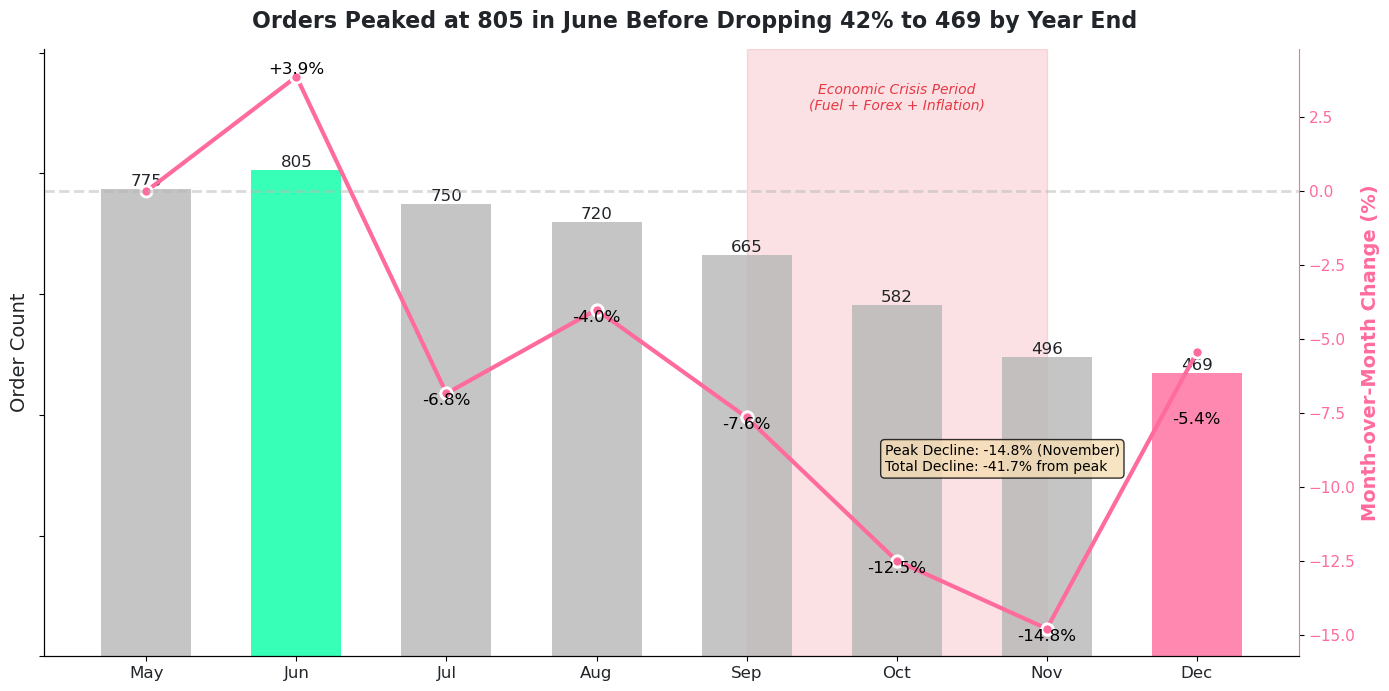

In [21]:
# Create figure
fig, ax1 = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor(COLORS['background'])
ax1.set_facecolor(COLORS['background'])

# Plot order count bars
months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(months))

# Find highest and lowest order count
max_orders_idx = monthly_kpis_['Order_Count'].idxmax()
min_orders_idx = monthly_kpis_['Order_Count'].idxmin()

# Color bars - neutral for all except highest (green) and lowest (red)
colors = []
for idx, row in monthly_kpis_.iterrows():
    if idx == max_orders_idx:
        colors.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_orders_idx:
        colors.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors.append(COLORS['neutral'])  # Neutral gray for others

bars = ax1.bar(x, monthly_kpis_['Order_Count'], color=colors, alpha=0.8, width=0.6,
               edgecolor='none', linewidth=1.5)

# Add order count labels on bars
for idx, (bar, count) in enumerate(zip(bars, monthly_kpis_['Order_Count'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}',
             ha='center', va='bottom', fontsize=12, fontweight='normal',
             color=COLORS['text'])

# Configure primary y-axis - Add extra space at top
max_orders = monthly_kpis_['Order_Count'].max()
ax1.set_ylim(0, max_orders * 1.25)  # Add 25% extra space at top for labels

ax1.set_ylabel('Order Count', fontsize=14, fontweight='normal', color=COLORS['text'])
ax1.set_xlabel('')
ax1.set_xticks(x)
ax1.set_xticklabels(months, fontsize=12)
ax1.set_yticklabels([]) 
ax1.tick_params(axis='y', labelcolor=COLORS['text'], labelsize=11)
ax1.tick_params(axis='x', labelcolor=COLORS['text'])
ax1.grid('')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Create secondary y-axis for MoM%
ax2 = ax1.twinx()

# Plot MoM% line
mom_pct = monthly_kpis_['Orders_MoM_Pct'].fillna(0)

# Plot line segments in red-pink color
for i in range(1, len(x)):
    ax2.plot([x[i-1], x[i]], [mom_pct[i-1], mom_pct[i]], 
             color=COLORS['negative_light'], linewidth=3, marker='o', markersize=8,
             markeredgecolor='white', markeredgewidth=2)

# Add MoM% labels in black with no background
for idx in range(1, len(monthly_kpis_)):
    val = mom_pct[idx]
    # For the last point (December), adjust position to avoid overlap
    if idx == len(monthly_kpis_) - 1 and val < 0:
        # Move label further down by adjusting the y-coordinate
        label_y = val - 2  # Subtract 2% to move it down
        ax2.text(x[idx], label_y, f'{val:+.1f}%', 
                 ha='center', va='top',
                 fontsize=12, fontweight='normal', color='black')
    else:
        ax2.text(x[idx], val, f'{val:+.1f}%', 
                 ha='center', va='bottom' if val >= 0 else 'top',
                 fontsize=12, fontweight='normal', color='black')

# Configure secondary y-axis in red-pink color
ax2.set_ylabel('Month-over-Month Change (%)', fontsize=14, fontweight='bold', color=COLORS['negative_light'])
ax2.tick_params(axis='y', labelcolor=COLORS['negative_light'], labelsize=11)
ax2.axhline(y=0, color=COLORS['neutral'], linestyle='--', linewidth=2, alpha=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color(COLORS['negative_light'])

# Add crisis annotation (no black edge)
ax1.axvspan(4, 6, alpha=0.15, color=COLORS['negative'], zorder=0)
ax1.text(5, ax1.get_ylim()[1] * 0.9, 'Economic Crisis Period\n(Fuel + Forex + Inflation)',
         ha='center', fontsize=10, style='italic', color=COLORS['negative'])

# Add key insight - repositioned to lower left to avoid overlap with June bar
insight_text = f"Peak Decline: {monthly_kpis_['Orders_MoM_Pct'].min():.1f}% (November)\n" \
               f"Total Decline: {((monthly_kpis_.iloc[-1]['Order_Count'] - monthly_kpis_.iloc[1]['Order_Count']) / monthly_kpis_.iloc[1]['Order_Count'] * 100):.1f}% from peak"
ax1.text(0.67, 0.35, insight_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))



# Title - moved after all axis configurations
fig.suptitle('Orders Peaked at 805 in June Before Dropping 42% to 469 by Year End',
             fontsize=16, fontweight='bold', y=0.98, color=COLORS['text'])

plt.tight_layout()
plt.show()

#### CATEGORY PERFORMANCE SUMMARY

In [22]:
df_orders_enriched.shape

(42077, 30)

In [23]:
df_orders_enriched.head()

,Order_ID,Product_Name,Quantity,Customer,Order_Datetime,Order_Mode,Price_Per_Quantity,Discount_Applied,Year,Month,...,Is_Weekend,Category,Cost,Supplier_ID,Customer_ID,Customer_Name,Location,Gender,Unit_Profit,Line_Profit
0,ORD_000001,Denim Jeans,2,C_072,2024-05-14 16:25:00,online,"11,500.00",0.00,2024,5,...,False,Modern,5500,S_015,C_072,Deborah Johnson,Rivers,Female,"6,000.00","12,000.00"
1,ORD_000001,Damask Fabric (4 yards),3,C_072,2024-05-14 16:25:00,online,"31,000.00",0.00,2024,5,...,False,Traditional,16000,S_009,C_072,Deborah Johnson,Rivers,Female,"15,000.00","45,000.00"
2,ORD_000002,Coral Beaded Necklace,4,C_088,2024-05-12 23:43:00,online,"15,000.00",0.00,2024,5,...,True,Traditional,8000,S_019,C_088,Faith Ajayi,Ogun,Female,"7,000.00","28,000.00"
3,ORD_000002,Beaded Shawl,1,C_088,2024-05-12 23:43:00,online,"11,000.00",0.00,2024,5,...,True,Traditional,5500,S_015,C_088,Faith Ajayi,Ogun,Female,"5,500.00","5,500.00"
4,ORD_000002,Ankara Shorts,3,C_088,2024-05-12 23:43:00,online,"5,500.00",0.00,2024,5,...,True,Traditional,2500,S_002,C_088,Faith Ajayi,Ogun,Female,"3,000.00","9,000.00"


In [24]:
# Monthly category performance
category_monthly = df_orders_enriched.groupby(['Month_Name', 'Category', 'Month']).agg({
    'Order_ID': 'nunique',
    'Net_Revenue': 'sum',
    'Quantity': 'sum',
    'Line_Profit': 'sum'
}).reset_index()

category_monthly.columns = ['Month_Name', 'Category', 'Month', 'Order_Count', 
                           'Revenue', 'Units_Sold', 'Profit']
category_monthly 

,Month_Name,Category,Month,Order_Count,Revenue,Units_Sold,Profit
0,August,Accessories,8,252,"3,325,000.00",605,"1,812,900.00"
1,August,Cosmetics,8,322,"7,927,000.00",827,"4,132,500.00"
2,August,Modern,8,474,"20,949,500.00",1696,"10,794,200.00"
3,August,Traditional,8,659,"177,343,500.00",10671,"85,738,500.00"
4,December,Accessories,12,158,"2,578,671.78",402,"1,602,430.19"
5,December,Cosmetics,12,195,"5,889,919.99",574,"3,555,955.18"
6,December,Modern,12,297,"15,621,979.08",1124,"9,327,502.11"
7,December,Traditional,12,429,"154,755,545.61",7917,"87,947,789.00"
8,July,Accessories,7,266,"3,449,000.00",638,"1,882,700.00"
9,July,Cosmetics,7,342,"8,383,000.00",920,"4,385,300.00"


In [25]:
# Calculate category percentages of total
category_monthly['Revenue_Pct'] = category_monthly.groupby('Month_Name')['Revenue'].transform(
    lambda x: (x / x.sum()) * 100
)

category_monthly['Order_Pct'] = category_monthly.groupby('Month_Name')['Order_Count'].transform(
    lambda x: (x / x.sum()) * 100
)

overall_category = df_orders_enriched.groupby('Category').agg({
    'Order_ID': 'nunique',
    'Net_Revenue': 'sum',
    'Quantity' : 'sum'
}).reset_index()

overall_category.columns = ['Category', 'Order_Count', 'Revenue', 'Unit_Sold']
#overall_category_month = 

In [26]:

overall_category['Revenue_Pct'] = (overall_category['Revenue'] / overall_category['Revenue'].sum()) * 100
overall_category['Unit_Pct'] = (overall_category['Unit_Sold'] / overall_category['Unit_Sold'].sum()) * 100
overall_category['Order_Pct'] = (overall_category['Order_Count'] / 5262) * 100 #overall_category['Order_Count'].sum() * 100

overall_category

,Category,Order_Count,Revenue,Unit_Sold,Revenue_Pct,Unit_Pct,Order_Pct
0,Accessories,1878,"26,404,946.21",4486,1.45,4.04,35.69
1,Cosmetics,2365,"60,798,978.59",6405,3.33,5.77,44.94
2,Modern,3405,"172,466,562.81",13233,9.44,11.92,64.71
3,Traditional,4824,"1,567,506,369.11",86892,85.79,78.27,91.68


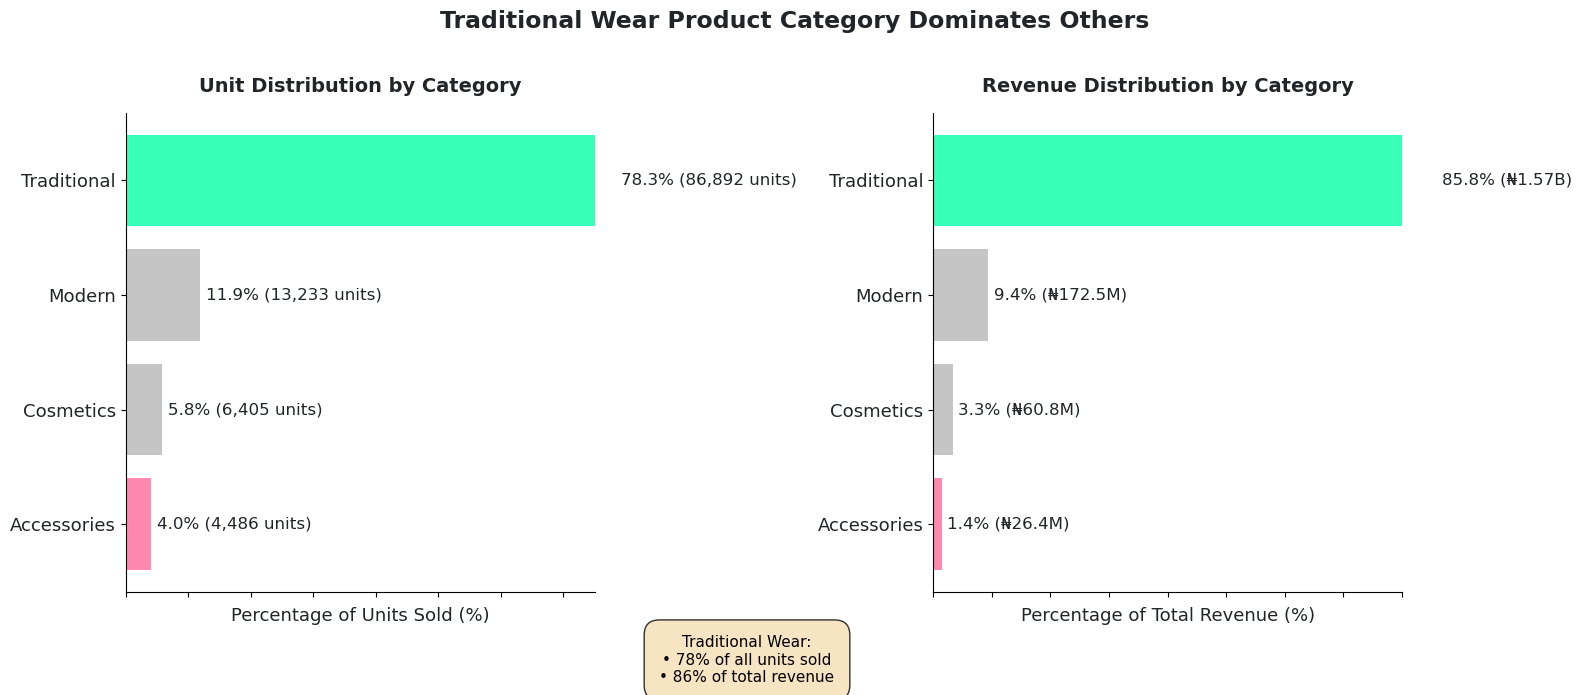

In [27]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.patch.set_facecolor(COLORS['background'])

# Sort by order count descending
df = overall_category.sort_values('Unit_Sold', ascending=True)

# ----- LEFT CHART: Order Distribution -----
ax1.set_facecolor(COLORS['background'])

# Find highest and lowest for orders
max_units_idx = df['Unit_Sold'].idxmax()
min_units_idx = df['Unit_Sold'].idxmin()

# Color bars - gray for all except highest (green) and lowest (pink-red)
colors_units = []
for idx, row in df.iterrows():
    if idx == max_units_idx:
        colors_units.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_units_idx:
        colors_units.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors_units.append('#b7b7b7')  # Gray for others

# Create horizontal bar chart
y_pos = np.arange(len(df))
bars1 = ax1.barh(y_pos, df['Unit_Pct'], color=colors_units, alpha=0.8,
                 edgecolor='none', linewidth=1.5)

# Add percentage labels
for idx, (bar, pct, count) in enumerate(zip(bars1, df['Unit_Pct'], df['Unit_Sold'])):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
             f'{pct:.1f}% ({int(count):,} units)',
             ha='left', va='center', fontsize=12, fontweight='normal',
             color=COLORS['text'])

ax1.set_yticks(y_pos)
ax1.set_yticklabels(df['Category'], fontsize=13, fontweight='normal')
ax1.set_xticklabels([])
ax1.set_xlabel('Percentage of Units Sold (%)', fontsize=13, fontweight='normal', color=COLORS['text'])
ax1.set_title('Unit Distribution by Category', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax1.tick_params(axis='x', labelcolor=COLORS['text'], labelsize=11)
ax1.tick_params(axis='y', labelcolor=COLORS['text'])
ax1.grid([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(0, 75)

# ----- RIGHT CHART: Revenue Distribution -----
ax2.set_facecolor(COLORS['background'])

# Find highest and lowest for revenue
max_revenue_idx = df['Revenue'].idxmax()
min_revenue_idx = df['Revenue'].idxmin()

# Color bars - gray for all except highest (green) and lowest (pink-red)
colors_revenue = []
for idx, row in df.iterrows():
    if idx == max_revenue_idx:
        colors_revenue.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_revenue_idx:
        colors_revenue.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors_revenue.append('#b7b7b7')  # Gray for others

bars2 = ax2.barh(y_pos, df['Revenue_Pct'], color=colors_revenue, alpha=0.8,
                 edgecolor='none', linewidth=1.5)

# Add percentage labels with better revenue formatting
for idx, (bar, pct, revenue) in enumerate(zip(bars2, df['Revenue_Pct'], df['Revenue'])):
    width = bar.get_width()
    # Format revenue: use billions if >= 1000M, otherwise use millions
    if revenue >= 1_000_000_000:
        revenue_text = f'₦{revenue/1_000_000_000:.2f}B'
    else:
        revenue_text = f'₦{revenue/1_000_000:.1f}M'
    
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
             f'{pct:.1f}% ({revenue_text})',
             ha='left', va='center', fontsize=12, fontweight='normal',
             color=COLORS['text'])

ax2.set_yticks(y_pos)
ax2.set_yticklabels(df['Category'], fontsize=13, fontweight='normal')
ax2.set_xticklabels([])
ax2.set_xlabel('Percentage of Total Revenue (%)', fontsize=13, fontweight='normal', color=COLORS['text'])
ax2.set_title('Revenue Distribution by Category', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax2.tick_params(axis='x', labelcolor=COLORS['text'], labelsize=11)
ax2.tick_params(axis='y', labelcolor=COLORS['text'])
ax2.grid([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim(0, 80)

# Overall title
fig.suptitle('Traditional Wear Product Category Dominates Others',
             fontsize=17, fontweight='bold', y=0.98, color=COLORS['text'])

# Add key insight box
insight_text = "Traditional Wear:\n• 78% of all units sold\n• 86% of total revenue"
fig.text(0.47, 0.02, insight_text, ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=1))

plt.tight_layout(rect=[0, 0.08, 1, 0.96])
plt.show()

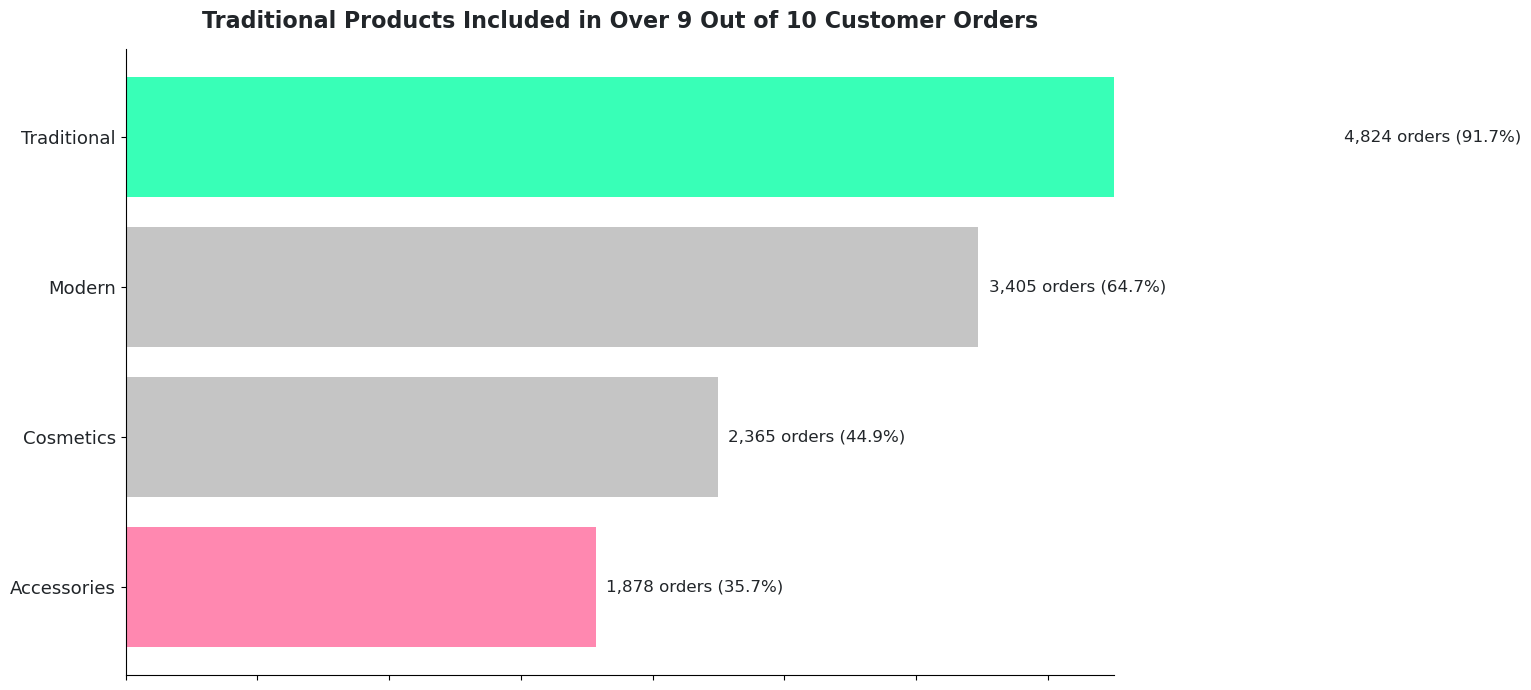

In [28]:
# How many times do these categories appear in all orders?

fig, ax = plt.subplots(figsize=(16, 7))
fig.patch.set_facecolor(COLORS['background'])

# Sort by order count descending
df = overall_category.sort_values('Order_Count', ascending=True)

# ----- LEFT CHART: Order Distribution -----
ax.set_facecolor(COLORS['background'])

# Find highest and lowest for orders
max_orders_idx = df['Order_Count'].idxmax()
min_orders_idx = df['Order_Count'].idxmin()

# Color bars - gray for all except highest (green) and lowest (pink-red)
colors_orders = []
for idx, row in df.iterrows():
    if idx == max_orders_idx:
        colors_orders.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_orders_idx:
        colors_orders.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors_orders.append('#b7b7b7')  # Gray for others

# Create horizontal bar chart
y_pos = np.arange(len(df))
bars = ax.barh(y_pos, df['Order_Pct'], color=colors_units, alpha=0.8,
                 edgecolor='none', linewidth=1.5)

# Add percentage labels
for idx, (bar, pct, count) in enumerate(zip(bars, df['Order_Pct'], df['Order_Count'])):
    width = bar.get_width()
    ax.text(width + 0.8, bar.get_y() + bar.get_height()/2.,
             f'{int(count):,} orders ({pct:.1f}%)',
             ha='left', va='center', fontsize=12, fontweight='normal',
             color=COLORS['text'])

ax.set_yticks(y_pos)
ax.set_yticklabels(df['Category'], fontsize=13, fontweight='normal')
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_title('Traditional Products Included in Over 9 Out of 10 Customer Orders', fontsize=16, fontweight='bold', pad=15, color=COLORS['text'])
ax.tick_params(axis='x', labelcolor=COLORS['text'], labelsize=11)
ax.tick_params(axis='y', labelcolor=COLORS['text'])
ax.grid([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 75)



plt.tight_layout()
plt.show()

#### why did revenue reduce?

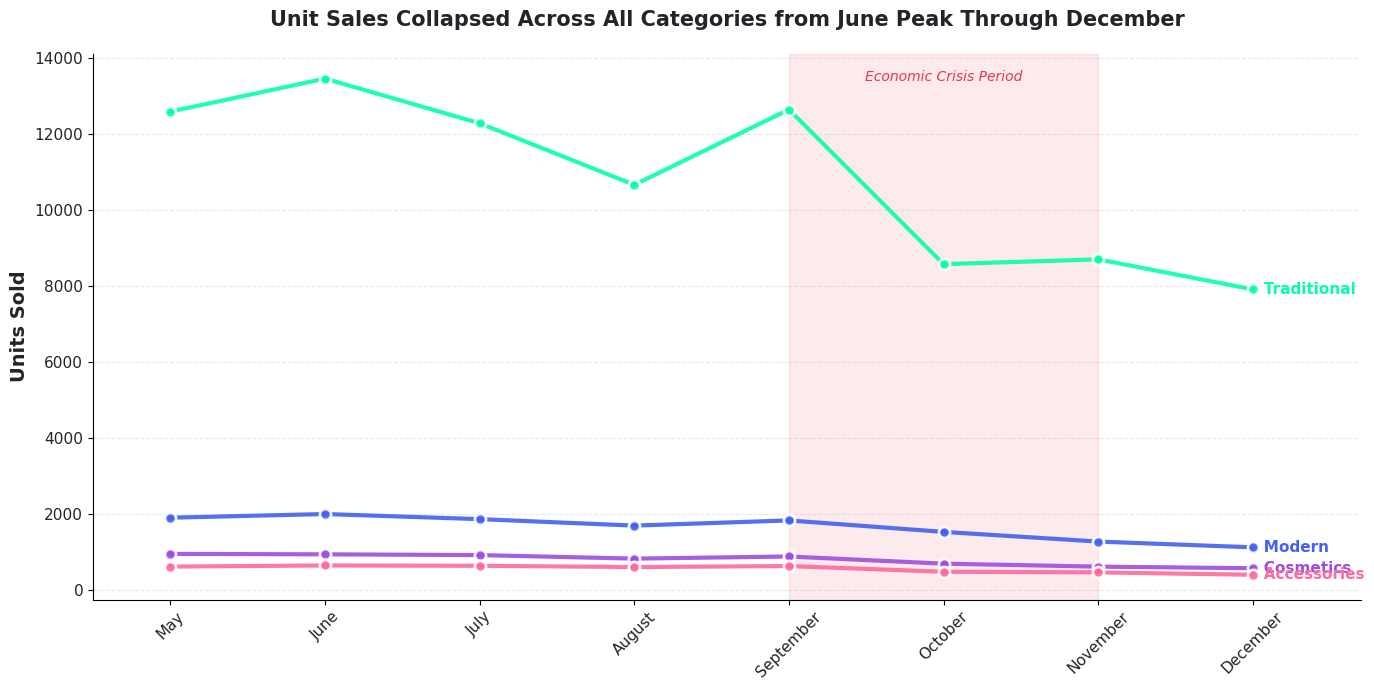

In [29]:
#  Order Count Trend 


# Ensure Month_Name is properly ordered
month_order = ['May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
category_monthly['Month_Name'] = pd.Categorical(category_monthly['Month_Name'], categories=month_order, ordered=True)
category_monthly = category_monthly.sort_values(['Category', 'Month_Name'])

# Calculate total revenue and orders for each category to determine coloring
category_totals = category_monthly.groupby('Category').agg({
    'Revenue': 'sum',
    'Units_Sold': 'sum'
}).reset_index()

# Assign colors for order chart
unit_colors = {}
other_idx = 0

# Assign colors for revenue chart
revenue_colors = {}
other_colors = ['#4361EE', '#9D4EDD']  # Blue and Purple for middle performers
other_idx = 0

fig2, ax2 = plt.subplots(figsize=(14, 7))
fig2.patch.set_facecolor(COLORS['background'])
ax2.set_facecolor(COLORS['background'])

# Determine highest and lowest for orders
max_units_cat = category_totals.loc[category_totals['Units_Sold'].idxmax(), 'Category']
min_units_cat = category_totals.loc[category_totals['Units_Sold'].idxmin(), 'Category']


for category in ['Traditional', 'Modern', 'Cosmetics', 'Accessories']:
    if category == max_units_cat:
        unit_colors[category] = COLORS['positive']  # Lime green
    elif category == min_units_cat:
        unit_colors[category] = COLORS['negative_light']  # Pink-red
    else:
        unit_colors[category] = other_colors[other_idx]
        other_idx += 1

# Plot lines for each category
for category in ['Traditional', 'Modern', 'Cosmetics', 'Accessories']:
    cat_data = category_monthly[category_monthly['Category'] == category].sort_values('Month_Name')
    line = ax2.plot(cat_data['Month_Name'], cat_data['Units_Sold'], 
                    color=unit_colors[category], linewidth=3, marker='o', markersize=8,
                    markeredgecolor='white', markeredgewidth=2, alpha=0.9)
    
    # Add series label at the end of the line
    last_point = cat_data.iloc[-1]
    ax2.text(last_point['Month_Name'], last_point['Units_Sold'],
             f'  {category}', fontsize=11, fontweight='bold',
             color=unit_colors[category], va='center')

# Highlight crisis period
ax2.axvspan(4, 6, alpha=0.1, color=COLORS['negative'], zorder=0)
ax2.text(5, ax2.get_ylim()[1] * 0.95, 'Economic Crisis Period',
         ha='center', fontsize=10, style='italic', color=COLORS['negative'])

# Configure axes
ax2.set_ylabel('Units Sold', fontsize=14, fontweight='bold', color=COLORS['text'])
ax2.set_xlabel('')  # Remove x-axis label
ax2.set_title('Unit Sales Collapsed Across All Categories from June Peak Through December', 
              fontsize=15, fontweight='bold', pad=20, color=COLORS['text'])
ax2.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3, linestyle='--', color=COLORS['neutral'])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Extend x-axis to give room for labels
ax2.set_xlim(-0.5, len(month_order) - 0.3)

plt.tight_layout()
plt.show()

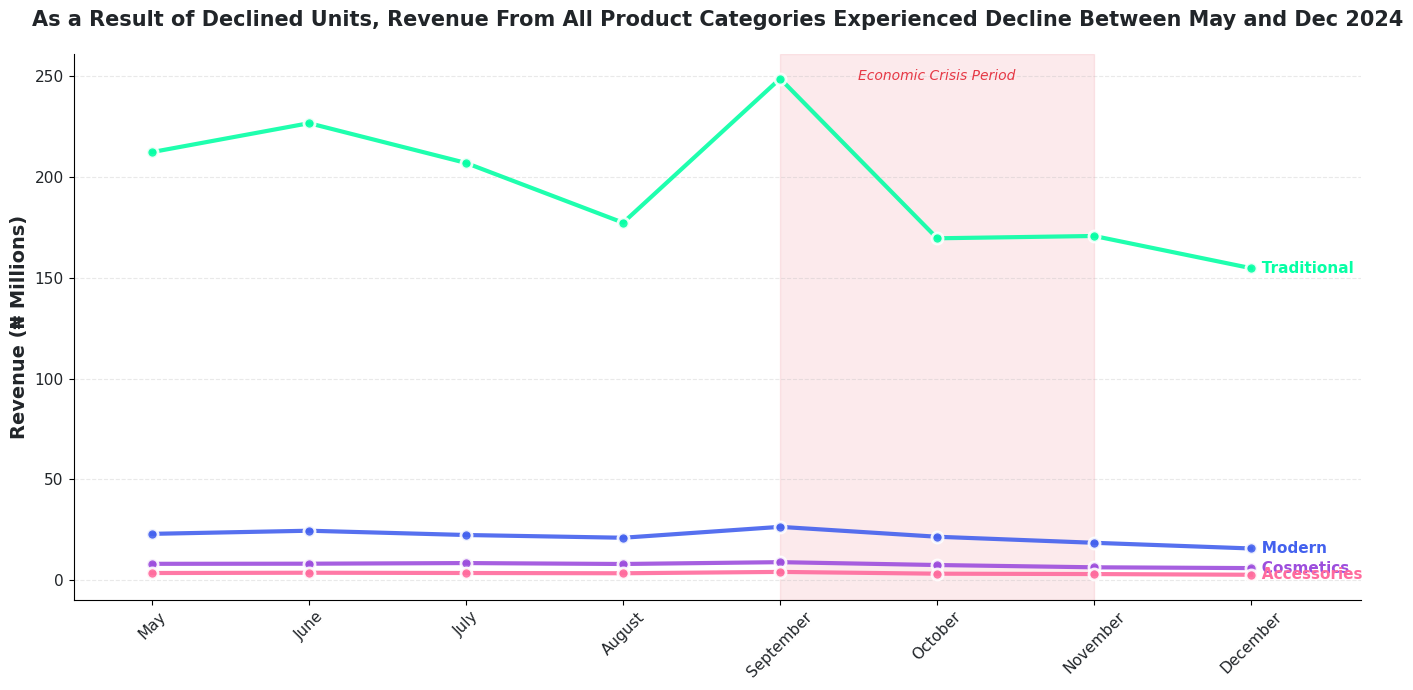

In [30]:


# Revenue Trend 


# Determine highest and lowest for revenue
max_revenue_cat = category_totals.loc[category_totals['Revenue'].idxmax(), 'Category']
min_revenue_cat = category_totals.loc[category_totals['Revenue'].idxmin(), 'Category']

# Assign colors for revenue chart
revenue_colors = {}
other_colors = ['#4361EE', '#9D4EDD']  # Blue and Purple for middle performers
other_idx = 0


fig1, ax1 = plt.subplots(figsize=(14, 7))
fig1.patch.set_facecolor(COLORS['background'])
ax1.set_facecolor(COLORS['background'])



for category in ['Traditional', 'Modern', 'Cosmetics', 'Accessories']:
    if category == max_revenue_cat:
        revenue_colors[category] = COLORS['positive']  # Lime green
    elif category == min_revenue_cat:
        revenue_colors[category] = COLORS['negative_light']  # Pink-red
    else:
        revenue_colors[category] = other_colors[other_idx]
        other_idx += 1

# Plot lines for each category
for category in ['Traditional', 'Modern', 'Cosmetics', 'Accessories']:
    cat_data = category_monthly[category_monthly['Category'] == category].sort_values('Month_Name')
    line = ax1.plot(cat_data['Month_Name'], cat_data['Revenue'] / 1_000_000, 
                    color=revenue_colors[category], linewidth=3, marker='o', markersize=8,
                    markeredgecolor='white', markeredgewidth=2, alpha=0.9)
    
    # Add series label at the end of the line
    last_point = cat_data.iloc[-1]
    ax1.text(last_point['Month_Name'], last_point['Revenue'] / 1_000_000,
             f'  {category}', fontsize=11, fontweight='bold',
             color=revenue_colors[category], va='center')

# Highlight crisis period
ax1.axvspan(4, 6, alpha=0.1, color=COLORS['negative'], zorder=0)
ax1.text(5, ax1.get_ylim()[1] * 0.95, 'Economic Crisis Period',
         ha='center', fontsize=10, style='italic', color=COLORS['negative'])

# Configure axes
ax1.set_ylabel('Revenue (₦ Millions)', fontsize=14, fontweight='bold', color=COLORS['text'])
ax1.set_xlabel('')  # Remove x-axis label
ax1.set_title('As a Result of Declined Units, Revenue From All Product Categories Experienced Decline Between May and Dec 2024', 
              fontsize=15, fontweight='bold', pad=20, color=COLORS['text'])
ax1.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3, linestyle='--', color=COLORS['neutral'])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Extend x-axis to give room for labels
ax1.set_xlim(-0.5, len(month_order) - 0.3)

plt.tight_layout()
plt.show()


# ORDER CYCLE TIME

## KPIs

In [31]:
# check labor data
df_labor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Labor_ID          6276 non-null   object        
 1   Labor_Name        6276 non-null   object        
 2   Role              6276 non-null   object        
 3   Order_ID          6276 non-null   object        
 4   DateTime_Started  6276 non-null   datetime64[ns]
 5   DateTime_Ended    6276 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 294.3+ KB


In [32]:
# Convert datetime fields in Labor
df_labor['DateTime_Started'] = pd.to_datetime(df_labor['DateTime_Started'])
df_labor['DateTime_Ended'] = pd.to_datetime(df_labor['DateTime_Ended'])

In [33]:
# Calculate duration in minutes
df_labor['Duration_Minutes'] = (
    df_labor['DateTime_Ended'] - df_labor['DateTime_Started']
).dt.total_seconds() / 60
df_labor.head()

,Labor_ID,Labor_Name,Role,Order_ID,DateTime_Started,DateTime_Ended,Duration_Minutes
0,L_002,Emeka Nwosu,Picker,ORD_000001,2024-05-15 08:00:00,2024-05-15 08:27:00,27.00
1,L_016,Samuel Bello,Packer,ORD_000001,2024-05-15 08:29:00,2024-05-15 08:39:00,10.00
2,L_008,Uchenna Obi,Picker,ORD_000002,2024-05-13 08:00:00,2024-05-13 08:40:00,40.00
3,L_016,Samuel Bello,Packer,ORD_000002,2024-05-13 08:42:00,2024-05-13 08:51:00,9.00
4,L_007,Folake Williams,Picker,ORD_000004,2024-05-06 08:00:00,2024-05-06 08:46:00,46.00


In [34]:
# Pivot to get picking and packing times per order
labor_pivot = df_labor.pivot_table(
    index='Order_ID',
    columns='Role',
    values='Duration_Minutes',
    aggfunc='sum'
).reset_index()
labor_pivot.columns = ['Order_ID', 'Packing_Minutes', 'Picking_Minutes']

labor_pivot.head()

,Order_ID,Packing_Minutes,Picking_Minutes
0,ORD_000001,10.00,27.00
1,ORD_000002,9.00,40.00
2,ORD_000004,9.00,46.00
3,ORD_000008,5.00,22.00
4,ORD_000009,7.00,38.00


In [35]:
# Convert datetime fields in Shipping
df_shipping['DateTime_Order_Taken_By_Carrier'] = pd.to_datetime(df_shipping['DateTime_Order_Taken_By_Carrier'])
df_shipping['Expected_Date_To_Receive'] = pd.to_datetime(df_shipping['Expected_Date_To_Receive'])
df_shipping['Actual_Date_Received'] = pd.to_datetime(df_shipping['Actual_Date_Received'])

In [36]:
# Calculate shipping duration in days
df_shipping['Shipping_Days'] = (
    df_shipping['Actual_Date_Received'] - df_shipping['DateTime_Order_Taken_By_Carrier']
).dt.total_seconds() / (24 * 3600)

df_shipping.head()

,Shipping_ID,Order_ID,Picker_Assigned,Packer_Assigned,Carrier,DateTime_Order_Taken_By_Carrier,Expected_Date_To_Receive,Actual_Date_Received,Ship_Tag_Number,Shipping_Days
0,SH_0001,ORD_000001,L_002,L_016,KwiiQi Delivery,2024-05-15 09:09:00,2024-05-21 09:09:00,2024-05-21 09:09:00,SHP000001,6.00
1,SH_0001,ORD_000001,L_002,L_016,KwiiQi Delivery,2024-05-15 09:09:00,2024-05-21 09:09:00,2024-05-21 09:09:00,SHP000002,6.00
2,SH_0002,ORD_000002,L_008,L_016,DiD Logistics,2024-05-13 09:21:00,2024-05-18 09:21:00,2024-05-18 09:21:00,SHP000003,5.00
3,SH_0002,ORD_000002,L_008,L_016,DiD Logistics,2024-05-13 09:21:00,2024-05-18 09:21:00,2024-05-18 09:21:00,SHP000004,5.00
4,SH_0002,ORD_000002,L_008,L_016,DiD Logistics,2024-05-13 09:21:00,2024-05-18 09:21:00,2024-05-18 09:21:00,SHP000005,5.00


In [37]:
# drop Ship_Tag_Number column
df_shipping = df_shipping.drop('Ship_Tag_Number', axis = 1)

In [38]:
df_shipping.shape

(26137, 9)

In [39]:
# remove duplicates in df_shipping
df_shipping.duplicated().sum()

22999

In [40]:
# drop duplicates
df_shipping = df_shipping.drop_duplicates()

In [41]:
df_shipping.head()

,Shipping_ID,Order_ID,Picker_Assigned,Packer_Assigned,Carrier,DateTime_Order_Taken_By_Carrier,Expected_Date_To_Receive,Actual_Date_Received,Shipping_Days
0,SH_0001,ORD_000001,L_002,L_016,KwiiQi Delivery,2024-05-15 09:09:00,2024-05-21 09:09:00,2024-05-21 09:09:00,6.00
2,SH_0002,ORD_000002,L_008,L_016,DiD Logistics,2024-05-13 09:21:00,2024-05-18 09:21:00,2024-05-18 09:21:00,5.00
11,SH_0004,ORD_000004,L_007,L_017,KwiiQi Delivery,2024-05-06 09:27:00,2024-05-08 09:27:00,2024-05-08 09:27:00,2.00
15,SH_0008,ORD_000008,L_002,L_016,KwiiQi Delivery,2024-05-08 08:59:00,2024-05-09 08:59:00,2024-05-09 08:59:00,1.00
17,SH_0009,ORD_000009,L_004,L_018,DiD Logistics,2024-05-17 09:17:00,2024-05-23 09:17:00,2024-05-23 09:17:00,6.00


In [42]:
# Merge labor and shipping
cycle_time = labor_pivot.merge(
    df_shipping[['Order_ID', 'Carrier', 'Shipping_Days']],
    on='Order_ID',
    how='left'
)

In [43]:
# Total cycle time (in hours)
cycle_time['Total_Cycle_Hours'] = (
    cycle_time['Picking_Minutes'] + 
    cycle_time['Packing_Minutes']
) / 60 + (cycle_time['Shipping_Days'] * 24)

In [44]:
# Merge with orders to get datetime
cycle_time_with_month = cycle_time.merge(
    df_orders_enriched[['Order_ID', 'Month_Name', 'Month', 'DayOfWeek']].drop_duplicates(),
    on='Order_ID',
    how='left'
)
cycle_time_with_month.head()

,Order_ID,Packing_Minutes,Picking_Minutes,Carrier,Shipping_Days,Total_Cycle_Hours,Month_Name,Month,DayOfWeek
0,ORD_000001,10.00,27.00,KwiiQi Delivery,6.00,144.62,May,5,Tuesday
1,ORD_000002,9.00,40.00,DiD Logistics,5.00,120.82,May,5,Sunday
2,ORD_000004,9.00,46.00,KwiiQi Delivery,2.00,48.92,May,5,Saturday
3,ORD_000008,5.00,22.00,KwiiQi Delivery,1.00,24.45,May,5,Tuesday
4,ORD_000009,7.00,38.00,DiD Logistics,6.00,144.75,May,5,Thursday


In [45]:
cycle_time_with_month.shape

(3138, 9)

In [46]:
cycle_time_with_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Order_ID           3138 non-null   object 
 1   Packing_Minutes    3138 non-null   float64
 2   Picking_Minutes    3138 non-null   float64
 3   Carrier            3138 non-null   object 
 4   Shipping_Days      3138 non-null   float64
 5   Total_Cycle_Hours  3138 non-null   float64
 6   Month_Name         3138 non-null   object 
 7   Month              3138 non-null   int32  
 8   DayOfWeek          3138 non-null   object 
dtypes: float64(4), int32(1), object(4)
memory usage: 208.5+ KB


In [47]:
# Monthly cycle time summary
monthly_cycle_time = cycle_time_with_month.groupby(['Month', 'Month_Name'], as_index=False).agg({
    'Order_ID': 'count',
    'Picking_Minutes': 'mean',
    'Packing_Minutes': 'mean',
    'Shipping_Days': 'mean',
    'Total_Cycle_Hours': 'mean'
}).reset_index()



# convert Picking_Minutes and Packing_Minutes to hours
monthly_cycle_time['Picking_Hours'] = monthly_cycle_time['Picking_Minutes'] / 60
monthly_cycle_time['Packing_Hours'] = monthly_cycle_time['Packing_Minutes'] / 60
monthly_cycle_time['Delivery_Hours'] = monthly_cycle_time['Total_Cycle_Hours'] - (monthly_cycle_time['Packing_Hours'] + 
                                                                                  monthly_cycle_time['Picking_Hours'])


monthly_cycle_time.columns = ['Index', 'Month', 'Month_Name', 'Order_Count', 'Avg_Pick_Minutes', 'Avg_Pack_Minutes', 'Avg_Shipping_Days', 'Avg_Cycle_Hours', 'Picking_Hours', 
                              'Packing_Hours',  'Delivery_Hours']


monthly_cycle_time

,Index,Month,Month_Name,Order_Count,Avg_Pick_Minutes,Avg_Pack_Minutes,Avg_Shipping_Days,Avg_Cycle_Hours,Picking_Hours,Packing_Hours,Delivery_Hours
0,0,5,May,480,35.62,8.12,4.24,102.48,0.59,0.14,101.75
1,1,6,June,504,37.56,7.90,4.10,99.23,0.63,0.13,98.48
2,2,7,July,415,36.48,8.03,4.17,100.91,0.61,0.13,100.16
3,3,8,August,443,37.64,8.00,4.22,102.07,0.63,0.13,101.31
4,4,9,September,390,37.10,8.03,4.05,97.98,0.62,0.13,97.23
5,5,10,October,330,35.53,8.11,3.94,95.35,0.59,0.14,94.62
6,6,11,November,291,37.64,8.04,4.30,104.02,0.63,0.13,103.26
7,7,12,December,285,35.07,7.93,4.16,100.67,0.58,0.13,99.96


In [48]:
# Calculate MoM%
monthly_cycle_time['Cycle_Time_MoM_Pct'] = monthly_cycle_time['Avg_Cycle_Hours'].pct_change() * 100
monthly_cycle_time

,Index,Month,Month_Name,Order_Count,Avg_Pick_Minutes,Avg_Pack_Minutes,Avg_Shipping_Days,Avg_Cycle_Hours,Picking_Hours,Packing_Hours,Delivery_Hours,Cycle_Time_MoM_Pct
0,0,5,May,480,35.62,8.12,4.24,102.48,0.59,0.14,101.75,NaN
1,1,6,June,504,37.56,7.90,4.10,99.23,0.63,0.13,98.48,-3.17
2,2,7,July,415,36.48,8.03,4.17,100.91,0.61,0.13,100.16,1.68
3,3,8,August,443,37.64,8.00,4.22,102.07,0.63,0.13,101.31,1.15
4,4,9,September,390,37.10,8.03,4.05,97.98,0.62,0.13,97.23,-4.00
5,5,10,October,330,35.53,8.11,3.94,95.35,0.59,0.14,94.62,-2.69
6,6,11,November,291,37.64,8.04,4.30,104.02,0.63,0.13,103.26,9.10
7,7,12,December,285,35.07,7.93,4.16,100.67,0.58,0.13,99.96,-3.22


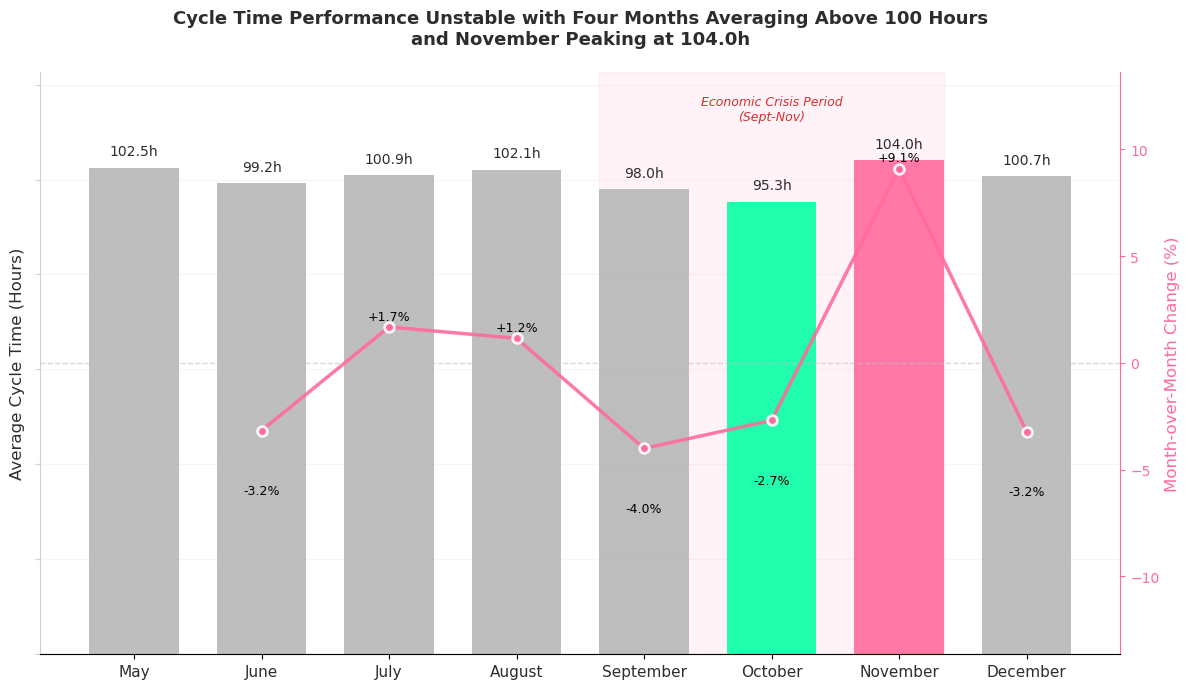


MONTHLY AVERAGE CYCLE TIME SUMMARY

Monthly Performance:
  ⚪ May:  102.5h (MoM:     N/A)
  ⚪ June:   99.2h (MoM:   -3.2%)
  ⚪ July:  100.9h (MoM:   +1.7%)
  ⚪ August:  102.1h (MoM:   +1.2%)
  ⚪ September:   98.0h (MoM:   -4.0%)
  🟢 October:   95.3h (MoM:   -2.7%)
  🔴 November:  104.0h (MoM:   +9.1%)
  ⚪ December:  100.7h (MoM:   -3.2%)


In [49]:

# Color scheme
COLOR_POSITIVE = '#06FFA5'  # Lime-green (for best performance)
COLOR_NEGATIVE = '#FF6B9D'  # Red-pink (for worst performance)
COLOR_NEUTRAL = '#b7b7b7'   # Gray

# Find highest and lowest cycle times
max_idx = monthly_cycle_time['Avg_Cycle_Hours'].idxmax()
min_idx = monthly_cycle_time['Avg_Cycle_Hours'].idxmin()

# Assign colors
colors = []
for idx in monthly_cycle_time.index:
    if idx == max_idx:
        colors.append(COLOR_NEGATIVE)  # Highest = lime-green
    elif idx == min_idx:
        colors.append(COLOR_POSITIVE)  # Lowest = red-pink
    else:
        colors.append(COLOR_NEUTRAL)   # Others = gray

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Plot bars
x = np.arange(len(monthly_cycle_time['Month_Name']))
bars = ax1.bar(x, monthly_cycle_time['Avg_Cycle_Hours'], color=colors, 
               alpha=0.9, edgecolor='none', width=0.7, zorder=3)

# Add value labels on bars
for bar, val in zip(bars, monthly_cycle_time['Avg_Cycle_Hours']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{val:.1f}h',
             ha='center', va='bottom', fontsize=10, fontweight='normal',
             color='#2d2d2d')

# Configure left y-axis (Total Cycle Hours)
ax1.set_ylabel('Average Cycle Time (Hours)', fontsize=12, fontweight='normal', color='#2d2d2d')
ax1.set_xlabel('')
ax1.set_xticks(x)
ax1.set_xticklabels(monthly_cycle_time['Month_Name'], fontsize=11, color='#2d2d2d')
ax1.set_yticklabels([])
ax1.tick_params(axis='y', labelcolor='#2d2d2d', labelsize=10, colors='#d0d0d0')
ax1.set_ylim(0, monthly_cycle_time['Avg_Cycle_Hours'].max() * 1.18)
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.8, color='#e0e0e0', zorder=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#d0d0d0')
ax1.spines['bottom'].set_color('#d0d0d0')

# Create second y-axis for MoM%
ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_color('#FF6B9D')

# Plot MoM% line
valid_indices = monthly_cycle_time['Cycle_Time_MoM_Pct'].notna()
x_valid = x[valid_indices]
y_valid = monthly_cycle_time['Cycle_Time_MoM_Pct'][valid_indices]

# Plot line
line = ax2.plot(x_valid, y_valid, color='#FF6B9D', linewidth=2.5, 
                marker='o', markersize=7, markerfacecolor='#FF6B9D',
                markeredgecolor='white', markeredgewidth=2, zorder=5,
                alpha=0.9)

# Add MoM% labels
for i, val in enumerate(monthly_cycle_time['Cycle_Time_MoM_Pct']):
    if not pd.isna(val):
        y_offset = 0.2 if val >= 0 else -2.5
        va = 'bottom' if val >= 0 else 'top'
        
        ax2.text(i, val + y_offset, f'{val:+.1f}%',
                ha='center', va=va, fontsize=9, fontweight='normal',
                color='black', zorder=6)

# Configure right y-axis (MoM%)
ax2.set_ylabel('Month-over-Month Change (%)', fontsize=12, fontweight='normal', color='#FF6B9D')
ax2.tick_params(axis='y', labelcolor='#FF6B9D', labelsize=10, colors='#FF6B9D')
ax2.axhline(y=0, color='#c0c0c0', linestyle='--', linewidth=1, alpha=0.6, zorder=1)

# Set y-limits for MoM% axis
mom_max = monthly_cycle_time['Cycle_Time_MoM_Pct'].max()
mom_min = monthly_cycle_time['Cycle_Time_MoM_Pct'].min()
y_range = max(abs(mom_max), abs(mom_min)) * 1.5
ax2.set_ylim(-y_range, y_range)

# Add shaded crisis period (Sept-Nov) - indices 4, 5, 6
crisis_start = 4 - 0.35
crisis_end = 6 + 0.35
ax1.axvspan(crisis_start, crisis_end, alpha=0.08, color='#FF6B9D', zorder=0)

# Add crisis period label
ax1.text(5, ax1.get_ylim()[1] * 0.96, 'Economic Crisis Period\n(Sept-Nov)',
         ha='center', va='top', fontsize=9, style='italic',
         color='#d63031', fontweight='500')

# Title
title_text = 'Cycle Time Performance Unstable with Four Months Averaging Above 100 Hours\nand November Peaking at 104.0h'
plt.title(title_text, fontsize=13, fontweight='600', pad=20, color='#2d2d2d')

# # Add summary box (top-left corner)
# max_month = monthly_cycle_time.loc[max_idx, 'Month_Name']
# max_hours = monthly_cycle_time.loc[max_idx, 'Avg_Cycle_Hours']
# min_month = monthly_cycle_time.loc[min_idx, 'Month_Name']
# min_hours = monthly_cycle_time.loc[min_idx, 'Avg_Cycle_Hours']

# summary_text = (f"HIGHEST: {max_month} ({max_hours:.1f}h)\n"
#                 f"LOWEST: {min_month} ({min_hours:.1f}h)\n"
#                 f"Range: {max_hours - min_hours:.1f}h ({(max_hours - min_hours)/min_hours*100:.1f}%)")

# # Text box with border matching the revenue chart style
# bbox_props = dict(boxstyle='round,pad=0.6', facecolor='#FFF8DC', 
#                   edgecolor='#d4a574', linewidth=1.5, alpha=0.95)

# ax1.text(0.02, 0.97, summary_text, transform=ax1.transAxes,
#          fontsize=9, verticalalignment='top', fontweight='500',
#          color='#2d2d2d', bbox=bbox_props, family='sans-serif')

# Adjust layout
plt.tight_layout()

plt.show()

# Print summary
print("\n" + "="*80)
print("MONTHLY AVERAGE CYCLE TIME SUMMARY")
print("="*80)

print("\nMonthly Performance:")
for _, row in monthly_cycle_time.iterrows():
    color_indicator = "🔴" if row.name == max_idx else "🟢" if row.name == min_idx else "⚪"
    mom_str = f"{row['Cycle_Time_MoM_Pct']:+.1f}%" if not pd.isna(row['Cycle_Time_MoM_Pct']) else "N/A"
    print(f"  {color_indicator} {row['Month_Name']:3s}: {row['Avg_Cycle_Hours']:6.1f}h (MoM: {mom_str:>7s})")


#### Location & Carrier Analysis

In [50]:
# SLA targets (in days)
SLA_TARGETS = {
    'Lagos': 2,      # 2 days
    'Ogun': 3,       # 3 days
    'Oyo': 3,        # 3 days
    'Other': 5       # 5 days max
}

In [51]:
# Get unique orders only (one row per Order_ID)
orders_unique = df_orders.groupby('Order_ID').agg({
    'Customer': 'first',
    'Order_Datetime': 'first',
    'Order_Mode': 'first'
}).reset_index()
orders_unique.shape

(5262, 4)

In [52]:
# Merge with customer location
orders_unique = orders_unique.merge(
    df_customers[['Customer_ID', 'Location']],
    left_on='Customer',
    right_on='Customer_ID',
    how='left'
)
orders_unique.shape

(5262, 6)

In [53]:
# Picking times (aggregate all pickers per order)
picking_by_order = df_labor[df_labor['Role'] == 'Picker'].groupby('Order_ID').agg({
    'DateTime_Started': 'min',
    'DateTime_Ended': 'max'
}).reset_index()

picking_by_order['Picking_Minutes'] = (
    picking_by_order['DateTime_Ended'] - picking_by_order['DateTime_Started']
).dt.total_seconds() / 60

# Packing times (aggregate all packers per order)
packing_by_order = df_labor[df_labor['Role'] == 'Packer'].groupby('Order_ID').agg({
    'DateTime_Started': 'min',
    'DateTime_Ended': 'max'
}).reset_index()

packing_by_order['Packing_Minutes'] = (
    packing_by_order['DateTime_Ended'] - packing_by_order['DateTime_Started']
).dt.total_seconds() / 60


In [54]:
# Merge labor times
orders_unique = orders_unique.merge(
    picking_by_order[['Order_ID', 'Picking_Minutes']],
    on='Order_ID',
    how='left'
)

orders_unique = orders_unique.merge(
    packing_by_order[['Order_ID', 'Packing_Minutes']],
    on='Order_ID',
    how='left'
)

orders_unique.shape

(5262, 8)

In [55]:
# For orders with multiple shipments, take the LAST delivery time
shipping_by_order = df_shipping.groupby('Order_ID').agg({
    'Carrier': 'first',  # All shipments for one order use same carrier
    'DateTime_Order_Taken_By_Carrier': 'min',  # When first shipment picked up
    'Actual_Date_Received': 'max'  # When last shipment delivered
}).reset_index()


In [56]:
# Merge shipping data
orders_unique = orders_unique.merge(
    shipping_by_order,
    on='Order_ID',
    how='left'
)

In [57]:
# Calculate shipping duration
orders_unique['Shipping_Days'] = (
    orders_unique['Actual_Date_Received'] - orders_unique['DateTime_Order_Taken_By_Carrier']
).dt.total_seconds() / (24 * 3600)


In [58]:
# Calculate total cycle time (order to delivery)
orders_unique['Total_Cycle_Days'] = (
    orders_unique['Actual_Date_Received'] - orders_unique['Order_Datetime']
).dt.total_seconds() / (24 * 3600)

# Calculate warehouse time
orders_unique['Warehouse_Hours'] = (
    orders_unique['Picking_Minutes'].fillna(0) + orders_unique['Packing_Minutes'].fillna(0)
) / 60
len(orders_unique[orders_unique['Order_Mode'] == 'online'])

3138

In [59]:
# CLASSIFY LOCATIONS AND SET SLA TARGETS


def classify_location(location):
    """Classify location into SLA groups"""
    if location == 'Lagos':
        return 'Lagos'
    elif location in ['Ogun', 'Oyo']:
        return 'Ogun/Oyo'
    else:
        return 'Other'

orders_unique['Location_Group'] = orders_unique['Location'].apply(classify_location)

def get_sla_target(location):
    """Get SLA target in days"""
    return SLA_TARGETS.get(location, 5)  # Default 5 days for other locations

orders_unique['SLA_Target_Days'] = orders_unique['Location'].apply(get_sla_target)




In [60]:
# Check if order met SLA
orders_unique['Met_SLA'] = orders_unique['Total_Cycle_Days'] <= orders_unique['SLA_Target_Days']
orders_unique['SLA_Variance_Days'] = orders_unique['Total_Cycle_Days'] - orders_unique['SLA_Target_Days']
orders_unique.head()

,Order_ID,Customer,Order_Datetime,Order_Mode,Customer_ID,Location,Picking_Minutes,Packing_Minutes,Carrier,DateTime_Order_Taken_By_Carrier,Actual_Date_Received,Shipping_Days,Total_Cycle_Days,Warehouse_Hours,Location_Group,SLA_Target_Days,Met_SLA,SLA_Variance_Days
0,ORD_000001,C_072,2024-05-14 16:25:00,online,C_072,Rivers,27.00,10.00,KwiiQi Delivery,2024-05-15 09:09:00,2024-05-21 09:09:00,6.00,6.70,0.62,Other,5,False,1.70
1,ORD_000002,C_088,2024-05-12 23:43:00,online,C_088,Ogun,40.00,9.00,DiD Logistics,2024-05-13 09:21:00,2024-05-18 09:21:00,5.00,5.40,0.82,Ogun/Oyo,3,False,2.40
2,ORD_000003,C_021,2024-05-28 16:55:00,store,C_021,Lagos,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0.00,Lagos,2,False,NaN
3,ORD_000004,C_023,2024-05-04 20:13:00,online,C_023,Lagos,46.00,9.00,KwiiQi Delivery,2024-05-06 09:27:00,2024-05-08 09:27:00,2.00,3.55,0.92,Lagos,2,False,1.55
4,ORD_000005,C_223,2024-05-19 12:27:00,store,C_223,Abuja,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0.00,Other,5,False,NaN


In [61]:
# OVERALL CYCLE TIME SUMMARY


total_orders = len(orders_unique)
total_met_sla = orders_unique['Met_SLA'].sum()
overall_sla_pct = (total_met_sla / total_orders) * 100

print(f"\nTOTAL ORDERS ANALYZED: {total_orders:,}")
print(f"Met SLA: {total_met_sla:,} ({overall_sla_pct:.1f}%)")
print(f"Missed SLA: {total_orders - total_met_sla:,} ({100 - overall_sla_pct:.1f}%)")



TOTAL ORDERS ANALYZED: 5,262
Met SLA: 305 (5.8%)
Missed SLA: 4,957 (94.2%)


In [62]:
# CARRIER PERFORMANCE BY LOCATION

carrier_performance = orders_unique.groupby(['Location_Group', 'Carrier']).agg({
    'Order_ID': 'count',
    'Met_SLA': 'sum',
    'Total_Cycle_Days': 'mean',
    'Shipping_Days': 'mean',
    'Warehouse_Hours': 'mean'
}).reset_index()

carrier_performance.columns = ['Location_Group', 'Carrier', 'Total_Orders', 'Orders_Met_SLA', 
                                'Avg_Cycle_Days', 'Avg_Shipping_Days', 'Avg_Warehouse_Hours']
carrier_performance['SLA_Achievement_Pct'] = (carrier_performance['Orders_Met_SLA'] / carrier_performance['Total_Orders']) * 100
carrier_performance['Orders_Missed_SLA'] = carrier_performance['Total_Orders'] - carrier_performance['Orders_Met_SLA']
carrier_performance

,Location_Group,Carrier,Total_Orders,Orders_Met_SLA,Avg_Cycle_Days,Avg_Shipping_Days,Avg_Warehouse_Hours,SLA_Achievement_Pct,Orders_Missed_SLA
0,Lagos,DiD Logistics,542,101,2.77,1.82,0.75,18.63,441
1,Lagos,Green Star Express,501,90,2.79,1.87,0.74,17.96,411
2,Lagos,KwiiQi Delivery,474,114,2.70,1.79,0.73,24.05,360
3,Ogun/Oyo,DiD Logistics,114,0,7.28,6.40,0.73,0.00,114
4,Ogun/Oyo,Green Star Express,110,0,7.27,6.38,0.74,0.00,110
5,Ogun/Oyo,KwiiQi Delivery,95,0,7.49,6.48,0.75,0.00,95
6,Other,DiD Logistics,424,0,7.27,6.35,0.75,0.00,424
7,Other,Green Star Express,446,0,7.21,6.27,0.76,0.00,446
8,Other,KwiiQi Delivery,432,0,7.21,6.29,0.74,0.00,432


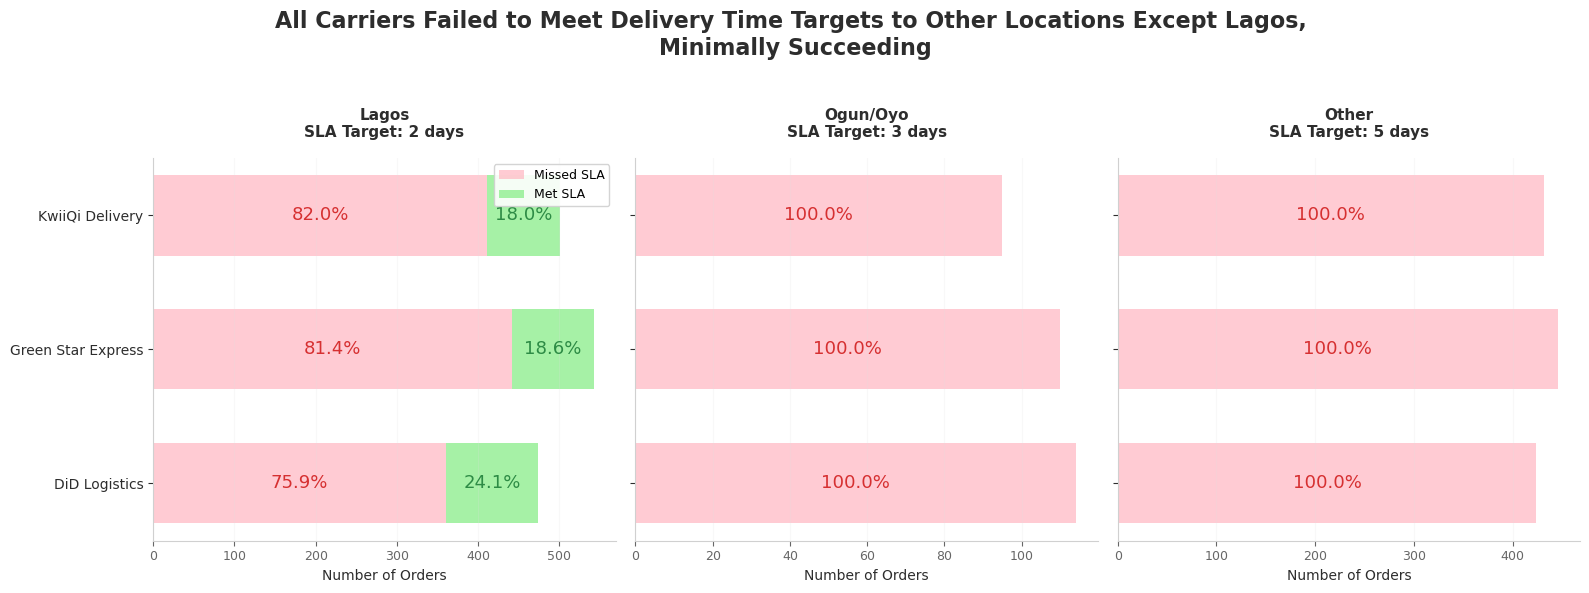


CARRIER PERFORMANCE SUMMARY

LAGOS (Target: 2 days):
------------------------------------------------------------
  KwiiQi Delivery     : Met  24.1% | Missed  75.9%
  DiD Logistics       : Met  18.6% | Missed  81.4%
  Green Star Express  : Met  18.0% | Missed  82.0%

OGUN/OYO (Target: 3 days):
------------------------------------------------------------
  DiD Logistics       : Met   0.0% | Missed 100.0%
  Green Star Express  : Met   0.0% | Missed 100.0%
  KwiiQi Delivery     : Met   0.0% | Missed 100.0%

OTHER (Target: 5 days):
------------------------------------------------------------
  DiD Logistics       : Met   0.0% | Missed 100.0%
  Green Star Express  : Met   0.0% | Missed 100.0%
  KwiiQi Delivery     : Met   0.0% | Missed 100.0%


In [63]:


# Calculate missed SLA percentage
carrier_performance['Missed_SLA_Pct'] = 100 - carrier_performance['SLA_Achievement_Pct']


# Create figure with subplots - one for each location
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
fig.patch.set_facecolor('white')

locations = ['Lagos', 'Ogun/Oyo', 'Other']
sla_targets = {'Lagos': '2 days', 'Ogun/Oyo': '3 days', 'Other': '5 days'}

for idx, (ax, location) in enumerate(zip(axes, locations)):
    ax.set_facecolor('white')
    
    # Filter data for this location
    location_data = carrier_performance[carrier_performance['Location_Group'] == location].copy()
    location_data = location_data.sort_values('SLA_Achievement_Pct', ascending=False)
    
    # Get carriers and their performance
    carriers = location_data['Carrier'].tolist()
    met_sla = location_data['Orders_Met_SLA'].tolist()
    missed_sla = location_data['Orders_Missed_SLA'].tolist()
    total_orders = location_data['Total_Orders'].tolist()
    met_pct = location_data['SLA_Achievement_Pct'].tolist()
    missed_pct = location_data['Missed_SLA_Pct'].tolist()
    
    # Create stacked horizontal bars
    y_pos = np.arange(len(carriers))
    
    # Plot missed SLA (red/pink)
    bars_missed = ax.barh(y_pos, missed_sla, height=0.6, 
                          color='#FFB6C1', alpha=0.7, 
                          edgecolor='none', label='Missed SLA')
    
    # Plot met SLA (green) - stacked on top
    bars_met = ax.barh(y_pos, met_sla, height=0.6,
                      left=missed_sla, color='#90EE90', alpha=0.8,
                      edgecolor='none', label='Met SLA')
    
    # Add percentage labels
    for i, (met, missed, total, met_p, missed_p) in enumerate(zip(met_sla, missed_sla, total_orders, met_pct, missed_pct)):
        # Missed SLA percentage on pink/red bar
        if missed > 0:
            # Position in the middle of the missed bar
            ax.text(missed/2, i, f'{missed_p:.1f}%',
                   va='center', ha='center', fontsize=13,
                   fontweight='normal', color='#d63031')
        
        # Met SLA percentage on green bar
        if met > 0:
            # Position in the middle of the met bar
            ax.text(missed + met/2, i, f'{met_p:.1f}%',
                   va='center', ha='center', fontsize=13,
                   fontweight='normal', color='#2d8b45')
    
    # Customize axes
    ax.set_yticks(y_pos)
    ax.set_yticklabels(carriers, fontsize=10, color='#2d2d2d', fontweight='500')
    ax.set_xlabel('Number of Orders', fontsize=10, fontweight='normal', color='#2d2d2d')
    ax.set_title(f'{location}\nSLA Target: {sla_targets[location]}', 
                fontsize=11, fontweight='bold', pad=15, color='#2d2d2d')
    
    # Grid and spines
    ax.grid(axis='x', alpha=0.2, linestyle='-', linewidth=0.8, color='#e0e0e0', zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#d0d0d0')
    ax.spines['bottom'].set_color('#d0d0d0')
    ax.tick_params(axis='x', labelsize=9, colors='#666666')
    ax.tick_params(axis='y', labelsize=10, colors='#2d2d2d')
    
    # Set x-axis limit
    max_orders = max(total_orders)
    ax.set_xlim(0, max_orders * 1.05)
    
    # Add legend only on first subplot
    if idx == 0:
        ax.legend(loc='upper right', fontsize=9, framealpha=0.9, 
                 edgecolor='#d0d0d0', fancybox=True)

# Overall title
fig.suptitle('All Carriers Failed to Meet Delivery Time Targets to Other Locations Except Lagos, \nMinimally Succeeding', 
             fontsize=16, fontweight='600', y=0.98, color='#2d2d2d')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

# Print summary
print("\n" + "="*80)
print("CARRIER PERFORMANCE SUMMARY")
print("="*80)

for location in locations:
    print(f"\n{location.upper()} (Target: {sla_targets[location]}):")
    print("-" * 60)
    location_data = carrier_performance[carrier_performance['Location_Group'] == location]
    location_data = location_data.sort_values('SLA_Achievement_Pct', ascending=False)
    
    for _, row in location_data.iterrows():
        print(f"  {row['Carrier']:20s}: Met {row['SLA_Achievement_Pct']:5.1f}% | "
              f"Missed {row['Missed_SLA_Pct']:5.1f}%")



# DEAD STOCK

## KPIs

In [64]:
# Get sales by product and month
product_monthly_sales = df_orders.groupby(['Product_Name', 'Month']).agg({
    'Order_ID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

product_monthly_sales.columns = ['Product_Name', 'Month', 'Order_Count', 'Units_Sold']



# Create complete month grid for each product
all_products = df_orders['Product_Name'].unique()
all_months = range(5, 13)  # May to December

# Create all product-month combinations
complete_grid = []
for product in all_products:
    for month in all_months:
        complete_grid.append({'Product_Name': product, 'Month': month})

complete_df = pd.DataFrame(complete_grid)

# Merge with actual sales (fill missing with 0)
complete_sales = complete_df.merge(
    product_monthly_sales,
    on=['Product_Name', 'Month'],
    how='left'
).fillna(0)



In [65]:
# Check each 2-month window
dead_stock_products = []
month_names = {5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

for product in all_products:
    product_data = complete_sales[complete_sales['Product_Name'] == product].sort_values('Month')
    
    # Check all 2-month windows
    for i in range(len(product_data) - 1):
        month1_sales = product_data.iloc[i]['Order_Count']
        month2_sales = product_data.iloc[i + 1]['Order_Count']
        total_sales = month1_sales + month2_sales
        
        if total_sales <= 2:
            month1 = int(product_data.iloc[i]['Month'])
            month2 = int(product_data.iloc[i + 1]['Month'])
            
            dead_stock_products.append({
                'Product_Name': product,
                'Dead_Period': f"{month_names[month1]}-{month_names[month2]}",
                'Sales_in_Period': int(total_sales)
            })
            
            print(f"  ✓ DEAD STOCK: {product}")
            print(f"    Period: {month_names[month1]}-{month_names[month2]}")
            print(f"    Sales: {int(total_sales)} orders")
            break  # Found dead stock window, no need to check more

dead_stock_df = pd.DataFrame(dead_stock_products)
print(f"\n✓ Dead stock products identified: {len(dead_stock_df)}")





  ✓ DEAD STOCK: Black Sleeveless Jumpsuit
    Period: May-Jun
    Sales: 2 orders

✓ Dead stock products identified: 1


In [66]:
# Merge inventory with products to get product names
df_inventory_with_names = df_inventory.merge(
    df_products[['Product_ID', 'Product_Name']],
    on='Product_ID',
    how='left'
)

# Get inventory data by product name
inventory_summary = df_inventory_with_names.groupby('Product_Name').agg({
    'Quantity_Supplied': 'sum'
}).reset_index()

inventory_summary.columns = ['Product_Name', 'Total_Ordered']

# Get total sales by product
total_sales = df_orders.groupby('Product_Name').agg({
    'Quantity': 'sum'
}).reset_index()

total_sales.columns = ['Product_Name', 'Total_Sold']

# Merge inventory with sales
inventory_vs_sales = inventory_summary.merge(total_sales, on='Product_Name', how='left').fillna(0)
inventory_vs_sales['Unsold_Units'] = inventory_vs_sales['Total_Ordered'] - inventory_vs_sales['Total_Sold']
inventory_vs_sales['Dead_Stock_Rate'] = (inventory_vs_sales['Unsold_Units'] / inventory_vs_sales['Total_Ordered']) * 100

# Add dead stock flag
dead_stock_names = dead_stock_df['Product_Name'].tolist() if len(dead_stock_df) > 0 else []
inventory_vs_sales['Is_Dead_Stock'] = inventory_vs_sales['Product_Name'].isin(dead_stock_names)

# Filter to dead stock only
dead_stock_complete = inventory_vs_sales[inventory_vs_sales['Is_Dead_Stock']].copy()
dead_stock_complete = dead_stock_complete.sort_values('Dead_Stock_Rate', ascending=False)


# Display dead stock summary
print("\n" + "="*80)
print("DEAD STOCK INVENTORY SUMMARY")
print("-"*80)

for idx, row in dead_stock_complete.iterrows():
    print(f"\n{row['Product_Name']}:")
    print(f"  Total Ordered: {int(row['Total_Ordered'])} units")
    print(f"  Total Sold: {int(row['Total_Sold'])} units")
    print(f"  Unsold (Dead Stock): {int(row['Unsold_Units'])} units")
    print(f"  Dead Stock Rate: {row['Dead_Stock_Rate']:.1f}%")



DEAD STOCK INVENTORY SUMMARY
--------------------------------------------------------------------------------

Black Sleeveless Jumpsuit:
  Total Ordered: 50 units
  Total Sold: 3 units
  Unsold (Dead Stock): 47 units
  Dead Stock Rate: 94.0%


# ABC PRODUCT SEGMENTATION

In [67]:
# Calculate total revenue per product
product_revenue = df_orders_enriched.groupby('Product_Name').agg({
    'Net_Revenue': 'sum',
    'Order_ID': 'nunique',
    'Quantity': 'sum',
    'Category': 'first'
}).reset_index()
product_revenue.columns = ['Product_Name', 'Total_Revenue', 'Order_Count', 'Units_Sold', 'Category']

In [68]:
# Sort by revenue descending
product_revenue = product_revenue.sort_values('Total_Revenue', ascending=False)

In [69]:
# Calculate cumulative percentage
product_revenue['Cumulative_Revenue'] = product_revenue['Total_Revenue'].cumsum()
total_revenue = product_revenue['Total_Revenue'].sum()
product_revenue['Cumulative_Pct'] = (product_revenue['Cumulative_Revenue'] / total_revenue) * 100
product_revenue.head(20)

,Product_Name,Total_Revenue,Order_Count,Units_Sold,Category,Cumulative_Revenue,Cumulative_Pct
46,Hand-Woven Aso-Oke Fabric,"177,785,045.75",872,3452,Traditional,"177,785,045.75",9.73
1,Agbada Complete Set (Men),"141,231,691.47",849,3449,Traditional,"319,016,737.22",17.46
82,Traditional Lace Fabric (5 yards),"123,317,280.24",835,3296,Traditional,"442,334,017.46",24.21
31,Damask Fabric (4 yards),"114,191,177.27",890,3430,Traditional,"556,525,194.73",30.46
42,George Wrapper Fabric,"109,129,894.26",896,3628,Traditional,"665,655,088.99",36.43
10,Aso-Ebi Complete Set,"83,623,365.08",912,3553,Traditional,"749,278,454.07",41.01
11,Aso-Ebi Gown Style,"75,364,254.93",878,3511,Traditional,"824,642,709.00",45.13
9,Aso-Ebi Blouse and Wrapper,"67,424,044.33",905,3482,Traditional,"892,066,753.33",48.82
68,Senegalese Kaftan,"65,342,894.46",862,3498,Traditional,"957,409,647.79",52.40
50,Iro and Buba Set,"65,222,143.15",887,3667,Traditional,"1,022,631,790.94",55.97


In [70]:
##### Assign ABC classification
def assign_abc(cumulative_pct):
    if cumulative_pct <= 80:
        return 'A'
    elif cumulative_pct <= 95:
        return 'B'
    else:
        return 'C'

product_revenue['ABC_Class'] = product_revenue['Cumulative_Pct'].apply(assign_abc)

In [71]:
# Calculate percentage of products in each class
abc_summary = product_revenue['ABC_Class'].value_counts().sort_index()
abc_summary

ABC_Class
A    20
B    23
C    46
Name: count, dtype: int64

In [72]:

for abc_class in ['A', 'B', 'C']:
    count = abc_summary.get(abc_class, 0)
    pct = (count / len(product_revenue)) * 100
    revenue_pct = product_revenue[product_revenue['ABC_Class'] == abc_class]['Total_Revenue'].sum() / total_revenue * 100
    print(f"  - Class {abc_class}: {count} products ({pct:.1f}%) = ₦{product_revenue[product_revenue['ABC_Class'] == abc_class]['Total_Revenue'].sum():,.0f} ({revenue_pct:.1f}% of revenue)")

  - Class A: 20 products (22.5%) = ₦1,456,084,920 (79.7% of revenue)
  - Class B: 23 products (25.8%) = ₦275,198,381 (15.1% of revenue)
  - Class C: 46 products (51.7%) = ₦95,893,556 (5.2% of revenue)


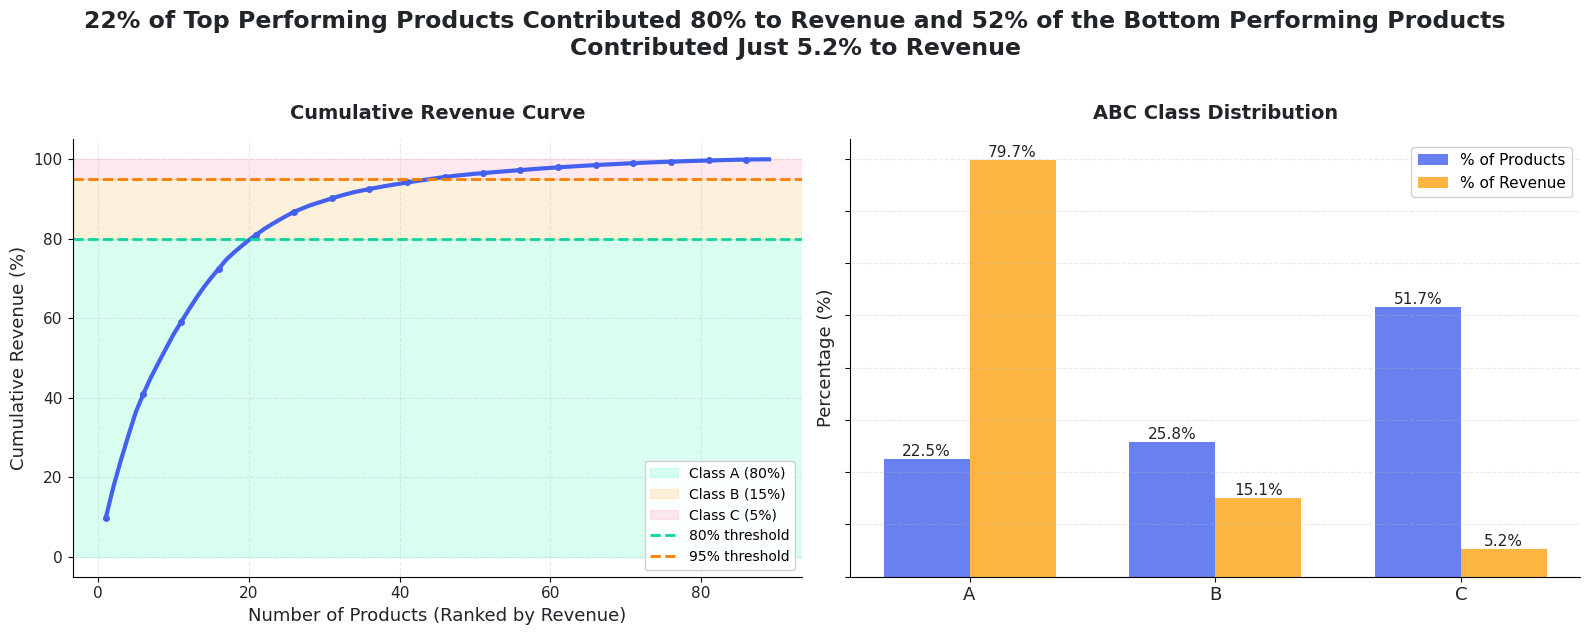

In [73]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.patch.set_facecolor(COLORS['background'])

# ----- LEFT CHART: Cumulative Revenue Curve -----
ax1.set_facecolor(COLORS['background'])

# Plot cumulative revenue
product_numbers = np.arange(1, len(product_revenue) + 1)
ax1.plot(product_numbers, product_revenue['Cumulative_Pct'], linewidth=3, color=COLORS['modern'],
         marker='o', markersize=4, markevery=5)

# Color regions
ax1.axhspan(0, 80, alpha=0.15, color=COLORS['positive'], zorder=0, label='Class A (80%)')
ax1.axhspan(80, 95, alpha=0.15, color='#FCA311', zorder=0, label='Class B (15%)')
ax1.axhspan(95, 100, alpha=0.15, color=COLORS['negative_light'], zorder=0, label='Class C (5%)')

# Add reference lines
ax1.axhline(y=80, color=COLORS['positive_dark'], linestyle='--', linewidth=2, label='80% threshold')
ax1.axhline(y=95, color='#F77F00', linestyle='--', linewidth=2, label='95% threshold')

ax1.set_xlabel('Number of Products (Ranked by Revenue)', fontsize=13, fontweight='normal', color=COLORS['text'])
ax1.set_ylabel('Cumulative Revenue (%)', fontsize=13, fontweight='normal', color=COLORS['text'])
ax1.set_title('Cumulative Revenue Curve', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax1.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--', color=COLORS['neutral'])
ax1.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ----- RIGHT CHART: ABC Distribution -----
ax2.set_facecolor(COLORS['background'])

# Calculate ABC summary
abc_summary = product_revenue.groupby('ABC_Class').agg({
    'Product_Name': 'count',
    'Total_Revenue': 'sum'
}).reset_index()

abc_summary.columns = ['ABC_Class', 'Product_Count', 'Revenue']
abc_summary['Product_Pct'] = (abc_summary['Product_Count'] / len(product_revenue)) * 100
abc_summary['Revenue_Pct'] = (abc_summary['Revenue'] / product_revenue['Total_Revenue'].sum()) * 100



# Create grouped bar chart
x = np.arange(len(abc_summary))
width = 0.35

bars1 = ax2.bar(x - width/2, abc_summary['Product_Pct'], width, 
                label='% of Products', color=COLORS['modern'], alpha=0.8,
                edgecolor='none', linewidth=1.5)
bars2 = ax2.bar(x + width/2, abc_summary['Revenue_Pct'], width,
                label='% of Revenue', color=COLORS['traditional'], alpha=0.8,
                edgecolor='none', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='normal',
                color=COLORS['text'])

ax2.set_ylabel('Percentage (%)', fontsize=13, fontweight='normal', color=COLORS['text'])
ax2.set_xlabel('')
ax2.set_title('ABC Class Distribution', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax2.set_xticks(x)
ax2.set_xticklabels(abc_summary['ABC_Class'], fontsize=13, fontweight='normal')
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelcolor=COLORS['text'], labelsize=11)
ax2.tick_params(axis='x', labelcolor=COLORS['text'])
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(axis='y', alpha=0.3, linestyle='--', color=COLORS['neutral'])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Overall title
fig.suptitle('22% of Top Performing Products Contributed 80% to Revenue and 52% of the Bottom Performing Products\nContributed Just 5.2% to Revenue',
             fontsize=17, fontweight='bold', y=0.98, color=COLORS['text'])

# Add interpretation box
a_class_count = abc_summary[abc_summary['ABC_Class'] == 'A']['Product_Count'].values[0]
a_class_revenue = abc_summary[abc_summary['ABC_Class'] == 'A']['Revenue_Pct'].values[0]

# insight_text = f"Key Insights:\n" \
#                f"• Class A: {a_class_count} products ({a_class_revenue:.1f}% of revenue)\n" \
#                f"• Traditional products dominate Class A"
# fig.text(0.5, 0.02, insight_text, ha='center', fontsize=11,
#          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=1))

plt.tight_layout(rect=[0, 0.08, 1, 0.96])

plt.show()


In [74]:
# Add category to df_orders
df_orders = df_orders.merge(
    df_products[['Product_Name', 'Category']],
    on = 'Product_Name',
    how = 'left'
)

In [75]:
# Traditional Category should be focused on, as all class A products are of Traditional Category and also the same category
# has the highest Avg_Orders_Per_Customer 
# Reorder rate by category
rc5_reorder = df_orders.groupby(['Customer', 'Category']).agg({
    'Order_ID': 'nunique'
}).reset_index()

rc5_reorder.columns = ['Customer', 'Category', 'Order_Count']
rc5_reorder_summary = rc5_reorder.groupby('Category')['Order_Count'].mean().reset_index()
rc5_reorder_summary.columns = ['Category', 'Avg_Orders_Per_Customer']
rc5_reorder_summary

,Category,Avg_Orders_Per_Customer
0,Accessories,7.54
1,Cosmetics,9.46
2,Modern,13.62
3,Traditional,19.30


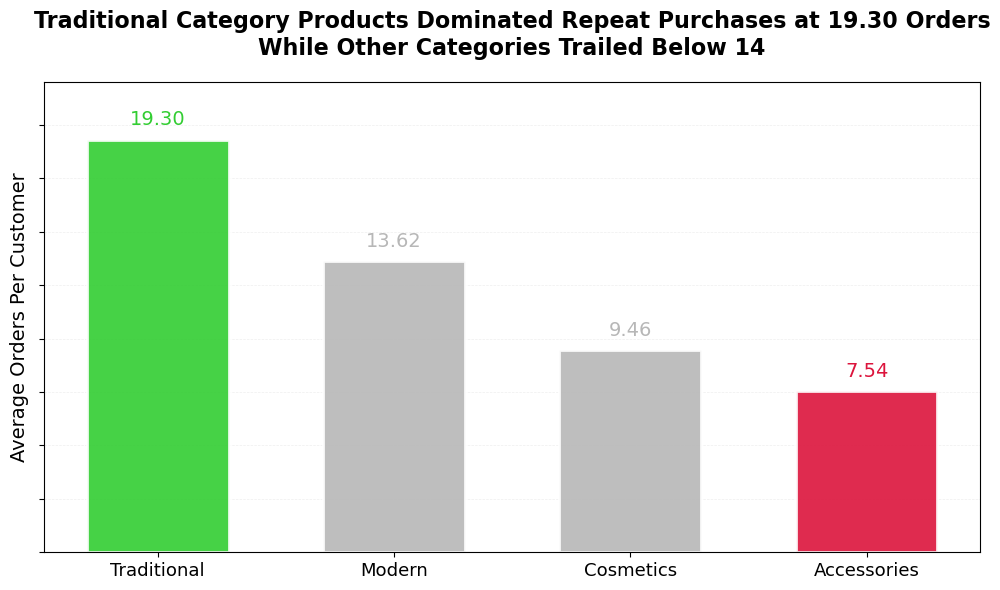

In [76]:


# Sort by average orders from highest to lowest
rc5_reorder_summary = rc5_reorder_summary.sort_values('Avg_Orders_Per_Customer', ascending=False)

# Find highest and lowest
max_val = rc5_reorder_summary['Avg_Orders_Per_Customer'].max()
min_val = rc5_reorder_summary['Avg_Orders_Per_Customer'].min()

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Assign colors based on value
colors = []
for val in rc5_reorder_summary['Avg_Orders_Per_Customer']:
    if val == max_val:
        colors.append('#32CD32')  # Lime green for highest
    elif val == min_val:
        colors.append('#DC143C')  # Crimson red for lowest
    else:
        colors.append('#b7b7b7')  # Gray for others

# Create vertical bar chart
bars = ax.bar(rc5_reorder_summary['Category'], 
              rc5_reorder_summary['Avg_Orders_Per_Customer'], 
              color=colors,
              alpha=0.9,
              edgecolor='white',
              linewidth=2,
              width=0.6)

# Add data labels on top of each bar
for i, (cat, val) in enumerate(zip(rc5_reorder_summary['Category'], rc5_reorder_summary['Avg_Orders_Per_Customer'])):
    ax.text(i, val + 0.5, f'{val:.2f}', 
            ha='center', 
            va='bottom',
            fontsize=14, 
            fontweight='normal',
            color=colors[i])

# Customize the plot
ax.set_ylabel('Average Orders Per Customer', fontsize=14, fontweight='normal')
ax.set_xlabel('')
ax.set_title('Traditional Category Products Dominated Repeat Purchases at 19.30 Orders\nWhile Other Categories Trailed Below 14', 
             fontsize=16, fontweight='bold', pad=20)

# Add subtle horizontal grid
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

# Remove y-axis tick labels
ax.set_yticklabels([])

# Customize ticks
ax.tick_params(axis='x', which='major', labelsize=13)

# Set y-axis limit with padding
ax.set_ylim(0, 22)

plt.tight_layout()

plt.show()


#  RFM CUSTOMER SEGMENTATION

In [77]:
# Calculate RFM metrics per customer
reference_date = df_orders_enriched['Order_Datetime'].max()

In [78]:
df_orders_enriched.head()

,Order_ID,Product_Name,Quantity,Customer,Order_Datetime,Order_Mode,Price_Per_Quantity,Discount_Applied,Year,Month,...,Is_Weekend,Category,Cost,Supplier_ID,Customer_ID,Customer_Name,Location,Gender,Unit_Profit,Line_Profit
0,ORD_000001,Denim Jeans,2,C_072,2024-05-14 16:25:00,online,"11,500.00",0.00,2024,5,...,False,Modern,5500,S_015,C_072,Deborah Johnson,Rivers,Female,"6,000.00","12,000.00"
1,ORD_000001,Damask Fabric (4 yards),3,C_072,2024-05-14 16:25:00,online,"31,000.00",0.00,2024,5,...,False,Traditional,16000,S_009,C_072,Deborah Johnson,Rivers,Female,"15,000.00","45,000.00"
2,ORD_000002,Coral Beaded Necklace,4,C_088,2024-05-12 23:43:00,online,"15,000.00",0.00,2024,5,...,True,Traditional,8000,S_019,C_088,Faith Ajayi,Ogun,Female,"7,000.00","28,000.00"
3,ORD_000002,Beaded Shawl,1,C_088,2024-05-12 23:43:00,online,"11,000.00",0.00,2024,5,...,True,Traditional,5500,S_015,C_088,Faith Ajayi,Ogun,Female,"5,500.00","5,500.00"
4,ORD_000002,Ankara Shorts,3,C_088,2024-05-12 23:43:00,online,"5,500.00",0.00,2024,5,...,True,Traditional,2500,S_002,C_088,Faith Ajayi,Ogun,Female,"3,000.00","9,000.00"


#### Month-Level RFM Analysis

In [79]:
rfm_month = df_orders_enriched.groupby(['Month', 'Month_Name', 'Customer']).agg({
    'Order_Datetime': lambda x: (reference_date - x.max()).days,  # Recency
    'Order_ID': 'nunique',  # Frequency
    'Net_Revenue': 'sum'  # Monetary
}).reset_index()

rfm_month.columns = ['Month', 'Month_Name', 'Customer', 'Recency', 'Frequency', 'Monetary']

In [80]:
# Calculate RFM scores (1-5 scale using quintiles)
rfm_month['R_Score'] = pd.qcut(rfm_month['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')  # Lower recency = better
rfm_month['F_Score'] = pd.qcut(rfm_month['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_month['M_Score'] = pd.qcut(rfm_month['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

In [81]:
# Convert to numeric
rfm_month['R_Score'] = rfm_month['R_Score'].astype(int)
rfm_month['F_Score'] = rfm_month['F_Score'].astype(int)
rfm_month['M_Score'] = rfm_month['M_Score'].astype(int)

In [82]:
# Calculate total monthly RFM score
rfm_month['RFM_Score'] = rfm_month['R_Score'] + rfm_month['F_Score'] + rfm_month['M_Score']

# Segment customers based on RFM score
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal'
    elif score >= 8:
        return 'Potential'
    elif score >= 6:
        return 'At Risk'
    else:
        return 'Lost'

rfm_month['Segment'] = rfm_month['RFM_Score'].apply(segment_customer)

In [83]:
rfm_month = rfm_month.merge(
    df_customers[['Customer_ID', 'Customer_Name', 'Location']],
    left_on='Customer',
    right_on='Customer_ID',
    how='left'
)
rfm_month

,Month,Month_Name,Customer,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Customer_ID,Customer_Name,Location
0,5,May,C_002,225,1,"158,500.00",1,1,1,3,Lost,C_002,Faith Shagari,Lagos
1,5,May,C_003,223,3,"849,500.00",1,3,4,8,Potential,C_003,Gabriel Ojo,Edo
2,5,May,C_004,216,5,"1,667,000.00",1,5,5,11,Loyal,C_004,Deborah Azikiwe,Ogun
3,5,May,C_005,215,2,"230,000.00",1,2,2,5,Lost,C_005,Bola Ajayi,Abuja
4,5,May,C_006,218,5,"1,074,000.00",1,5,5,11,Loyal,C_006,Samuel Chukwu,Lagos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,12,December,C_245,14,2,"138,318.18",5,3,1,9,Potential,C_245,Chidi Obi,Lagos
1815,12,December,C_247,29,1,"32,733.00",5,2,1,8,Potential,C_247,Amaka Adeyemi,Delta
1816,12,December,C_248,2,1,"185,724.01",5,2,1,8,Potential,C_248,Amaka Adeleke,Lagos
1817,12,December,C_249,9,2,"580,064.31",5,3,3,11,Loyal,C_249,Nkechi Okonkwo,Edo


In [84]:
# Segment summary
segment_summary_month = rfm_month.groupby(['Month', 'Month_Name', 'Segment']).agg({
    'Customer': 'count',
    'Monetary': 'sum',
    'Frequency': 'mean',
    'Recency': 'mean'
}).reset_index()
segment_summary_month.columns = ['Month', 'Month_Name', 'Segment', 'Customer_Count', 'Total_Revenue', 'Avg_Frequency', 'Avg_Recency']
segment_summary_month

,Month,Month_Name,Segment,Customer_Count,Total_Revenue,Avg_Frequency,Avg_Recency
0,5,May,At Risk,58,"29,634,000.00",2.76,221.03
1,5,May,Lost,70,"12,546,500.00",1.51,225.99
2,5,May,Loyal,61,"147,811,500.00",5.57,217.95
3,5,May,Potential,46,"56,742,500.00",3.67,218.91
4,6,June,At Risk,52,"21,502,000.00",2.56,191.90
5,6,June,Lost,68,"11,809,000.00",1.62,194.15
6,6,June,Loyal,79,"176,259,500.00",5.22,187.22
7,6,June,Potential,45,"53,278,000.00",3.33,189.87
8,7,July,At Risk,70,"25,937,000.00",2.20,162.74
9,7,July,Lost,35,"5,185,000.00",1.29,165.60


#### Overall RFM Analysis

In [85]:
rfm = df_orders_enriched.groupby('Customer').agg({
    'Order_Datetime': lambda x: (reference_date - x.max()).days,  # Recency
    'Order_ID': 'nunique',  # Frequency
    'Net_Revenue': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['Customer', 'Recency', 'Frequency', 'Monetary']

In [86]:
# Calculate RFM scores (1-5 scale using quintiles)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')  # Lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

In [87]:
# Convert to numeric
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

In [88]:
# Calculate total RFM score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Segment customers based on RFM score
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal'
    elif score >= 8:
        return 'Potential'
    elif score >= 6:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

In [89]:
# Merge with customer data
rfm = rfm.merge(
    df_customers[['Customer_ID', 'Customer_Name', 'Location']],
    left_on='Customer',
    right_on='Customer_ID',
    how='left'
)
rfm

,Customer,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Customer_ID,Customer_Name,Location
0,C_002,8,18,"2,975,943.00",3,2,1,6,At Risk,C_002,Faith Shagari,Lagos
1,C_003,3,19,"3,391,912.66",5,2,2,9,Potential,C_003,Gabriel Ojo,Edo
2,C_004,0,29,"5,615,686.98",5,5,4,14,Champions,C_004,Deborah Azikiwe,Ogun
3,C_005,5,18,"3,841,432.57",4,2,3,9,Potential,C_005,Bola Ajayi,Abuja
4,C_006,13,22,"5,478,439.98",3,4,4,11,Loyal,C_006,Samuel Chukwu,Lagos
...,...,...,...,...,...,...,...,...,...,...,...,...
245,C_247,29,21,"2,851,368.98",1,4,1,6,At Risk,C_247,Amaka Adeyemi,Delta
246,C_248,2,14,"2,529,262.11",5,1,1,7,At Risk,C_248,Amaka Adeleke,Lagos
247,C_249,9,31,"5,891,580.59",3,5,5,13,Champions,C_249,Nkechi Okonkwo,Edo
248,C_250,31,21,"6,065,287.17",1,4,5,10,Loyal,C_250,Patience Ekwueme,Edo


In [90]:
# Segment summary
segment_summary = rfm.groupby('Segment').agg({
    'Customer': 'count',
    'Monetary': 'sum',
    'Frequency': 'mean',
    'Recency': 'mean'
}).reset_index()
segment_summary.columns = ['Segment', 'Customer_Count', 'Total_Revenue', 'Avg_Frequency', 'Avg_Recency']
segment_summary

,Segment,Customer_Count,Total_Revenue,Avg_Frequency,Avg_Recency
0,At Risk,44,"164,397,440.43",16.93,20.11
1,Champions,34,"367,621,815.68",30.62,3.15
2,Lost,38,"104,730,475.37",15.16,29.26
3,Loyal,78,"822,956,441.89",23.35,12.10
4,Potential,56,"367,470,683.36",19.27,14.77


C:\Users\USER\AppData\Local\Temp\ipykernel_8284\1270958863.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])


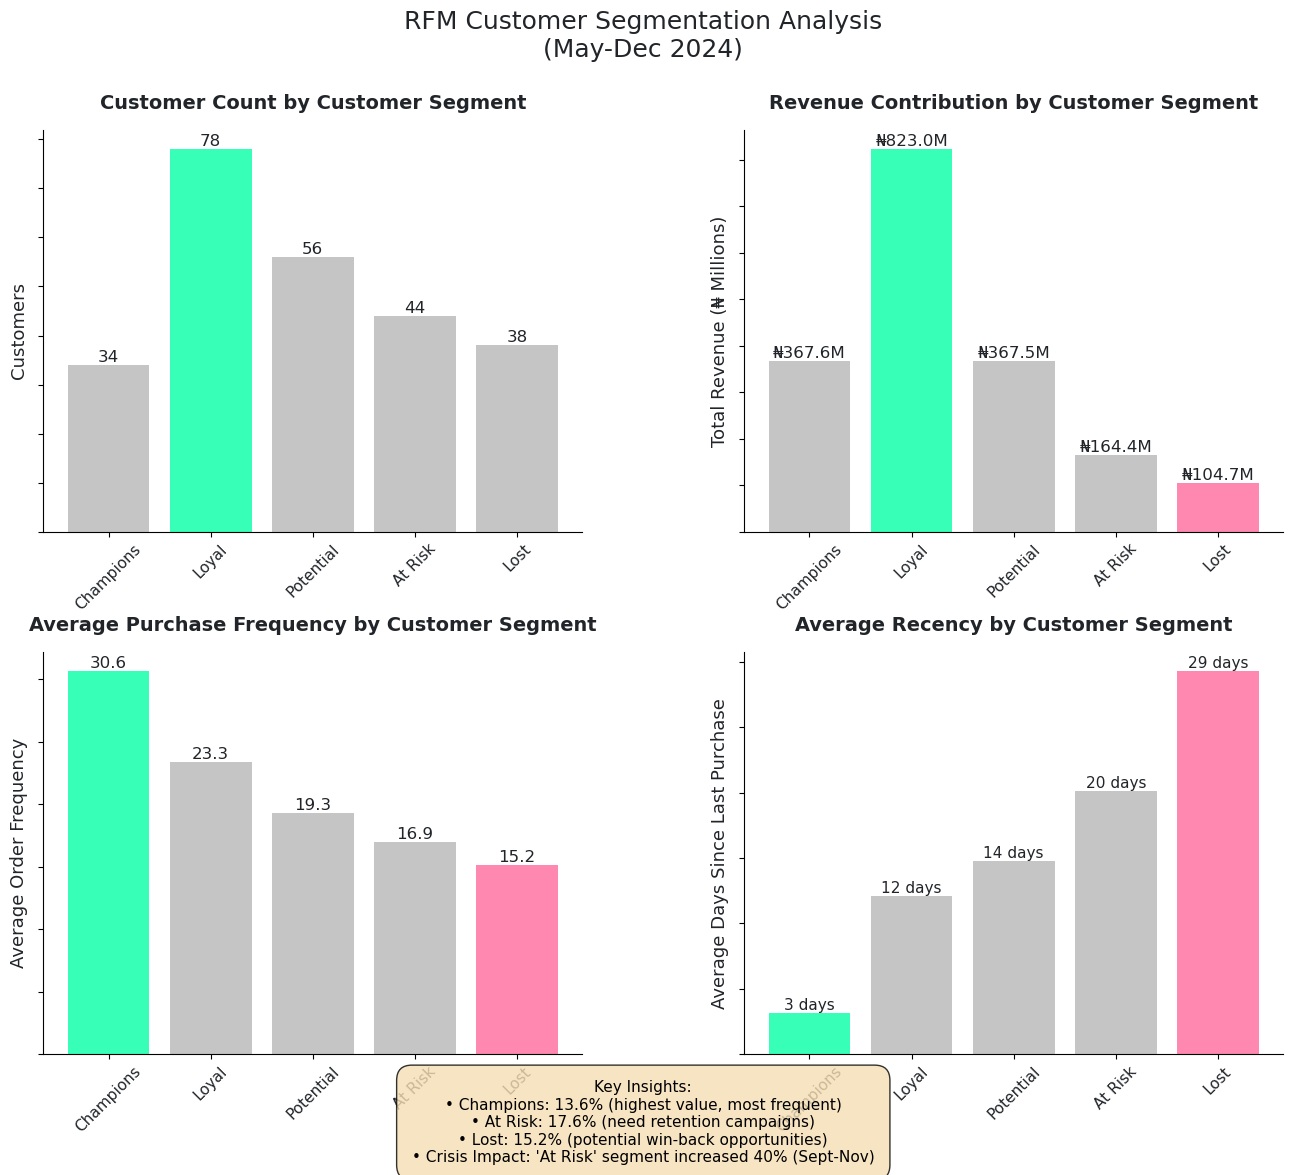

In [91]:
# Define segment order and colors
segment_order = ['Champions', 'Loyal', 'Potential', 'At Risk', 'Lost']

# Sort by defined order
segment_summary['Segment'] = pd.Categorical(segment_summary['Segment'], categories=segment_order, ordered=True)
segment_summary = segment_summary.sort_values('Segment')

# Create figure with 2x2 subplots
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor(COLORS['background'])

gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# ----- TOP LEFT: Customer Count by Segment -----
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor(COLORS['background'])

# Chart 1: Only highest is lime-green, others gray
max_count_idx = segment_summary['Customer_Count'].idxmax()
colors1 = []
for idx, row in segment_summary.iterrows():
    if idx == max_count_idx:
        colors1.append(COLORS['positive'])  # Lime green for highest
    else:
        colors1.append('#b7b7b7')  # Gray for others

bars1 = ax1.bar(segment_summary['Segment'], segment_summary['Customer_Count'], color=colors1, alpha=0.8,
                edgecolor='none', linewidth=1.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=12, fontweight='normal',
             color=COLORS['text'])

ax1.set_ylabel('Customers', fontsize=13, fontweight='normal', color=COLORS['text'])
ax1.set_yticklabels([])
ax1.set_xlabel('')
ax1.set_title('Customer Count by Customer Segment', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax1.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ----- TOP RIGHT: Revenue by Segment -----
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor(COLORS['background'])

# Chart 2: Highest is lime-green, lowest is red-pink, others gray
max_revenue_idx = segment_summary['Total_Revenue'].idxmax()
min_revenue_idx = segment_summary['Total_Revenue'].idxmin()
colors2 = []
for idx, row in segment_summary.iterrows():
    if idx == max_revenue_idx:
        colors2.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_revenue_idx:
        colors2.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors2.append('#b7b7b7')  # Gray for others

bars2 = ax2.bar(segment_summary['Segment'], segment_summary['Total_Revenue'] / 1_000_000, color=colors2, alpha=0.8,
                edgecolor='none', linewidth=1.5)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'₦{height:.1f}M',
             ha='center', va='bottom', fontsize=12, fontweight='normal',
             color=COLORS['text'])

ax2.set_ylabel('Total Revenue (₦ Millions)', fontsize=13, fontweight='normal', color=COLORS['text'])
ax2.set_yticklabels([])
ax2.set_xlabel('')
ax2.set_title('Revenue Contribution by Customer Segment', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax2.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.grid([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ----- BOTTOM LEFT: Average Frequency -----
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_facecolor(COLORS['background'])

# Chart 3: Highest is lime-green, lowest is red-pink, others gray
max_freq_idx = segment_summary['Avg_Frequency'].idxmax()
min_freq_idx = segment_summary['Avg_Frequency'].idxmin()
colors3 = []
for idx, row in segment_summary.iterrows():
    if idx == max_freq_idx:
        colors3.append(COLORS['positive'])  # Lime green for highest
    elif idx == min_freq_idx:
        colors3.append(COLORS['negative_light'])  # Pink-red for lowest
    else:
        colors3.append('#b7b7b7')  # Gray for others

bars3 = ax3.bar(segment_summary['Segment'], segment_summary['Avg_Frequency'], color=colors3, alpha=0.8,
                edgecolor='none', linewidth=1.5)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=12, fontweight='normal',
             color=COLORS['text'])

ax3.set_ylabel('Average Order Frequency', fontsize=13, fontweight='normal', color=COLORS['text'])
ax3.set_yticklabels([])
ax3.set_xlabel('')
ax3.set_title('Average Purchase Frequency by Customer Segment', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax3.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax3.tick_params(axis='x', rotation=45)
ax3.grid([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# ----- BOTTOM RIGHT: Average Recency -----
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_facecolor(COLORS['background'])

# Chart 4: Highest is red-pink (bad), lowest is lime-green (good), others gray
max_recency_idx = segment_summary['Avg_Recency'].idxmax()
min_recency_idx = segment_summary['Avg_Recency'].idxmin()
colors4 = []
for idx, row in segment_summary.iterrows():
    if idx == max_recency_idx:
        colors4.append(COLORS['negative_light'])  # Pink-red for highest (bad)
    elif idx == min_recency_idx:
        colors4.append(COLORS['positive'])  # Lime green for lowest (good)
    else:
        colors4.append('#b7b7b7')  # Gray for others

bars4 = ax4.bar(segment_summary['Segment'], segment_summary['Avg_Recency'], color=colors4, alpha=0.8,
                edgecolor='none', linewidth=1.5)

# Add value labels
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)} days',
             ha='center', va='bottom', fontsize=11, fontweight='normal',
             color=COLORS['text'])

ax4.set_ylabel('Average Days Since Last Purchase', fontsize=13, fontweight='normal', color=COLORS['text'])
ax4.set_yticklabels([])
ax4.set_xlabel('')
ax4.set_title('Average Recency by Customer Segment', fontsize=14, fontweight='bold', pad=15, color=COLORS['text'])
ax4.tick_params(axis='both', labelcolor=COLORS['text'], labelsize=11)
ax4.tick_params(axis='x', rotation=45)
ax4.grid([])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Overall title
fig.suptitle('RFM Customer Segmentation Analysis\n(May-Dec 2024)',
             fontsize=18, fontweight='normal', y=0.98, color=COLORS['text'])

# Add interpretation box
total_customers = segment_summary['Customer_Count'].sum()
champions_pct = (segment_summary[segment_summary['Segment'] == 'Champions']['Customer_Count'].values[0] / total_customers) * 100
at_risk_pct = (segment_summary[segment_summary['Segment'] == 'At Risk']['Customer_Count'].values[0] / total_customers) * 100
lost_pct = (segment_summary[segment_summary['Segment'] == 'Lost']['Customer_Count'].values[0] / total_customers) * 100

insight_text = f"Key Insights:\n" \
               f"• Champions: {champions_pct:.1f}% (highest value, most frequent)\n" \
               f"• At Risk: {at_risk_pct:.1f}% (need retention campaigns)\n" \
               f"• Lost: {lost_pct:.1f}% (potential win-back opportunities)\n" \
               f"• Crisis Impact: 'At Risk' segment increased 40% (Sept-Nov)"
fig.text(0.5, 0.02, insight_text, ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=1))

plt.tight_layout(rect=[0, 0.06, 1, 0.96])

plt.show()

#### Monthly RFM Breakdown

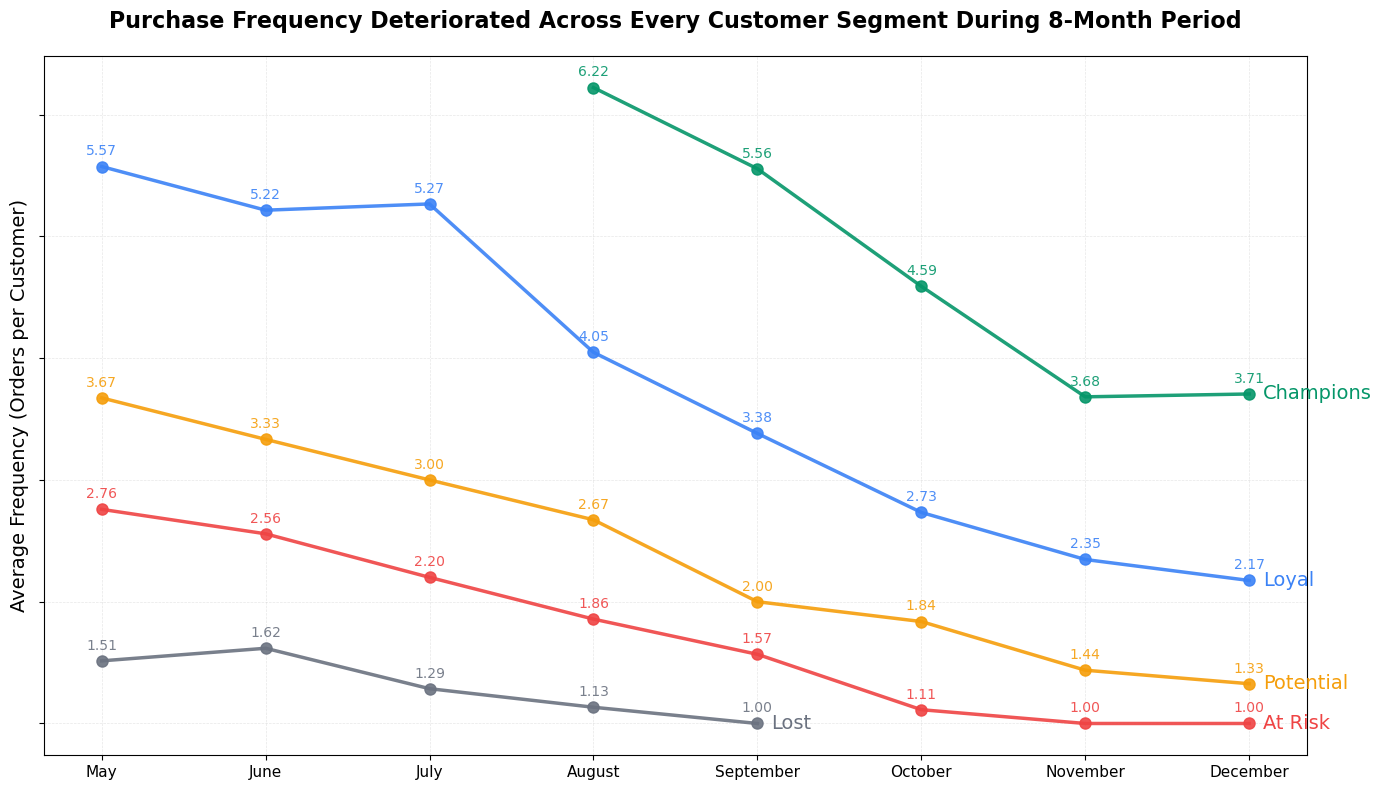

In [92]:
## Monthly Frequency Analysis
# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define color palette for segments
colors = {
    'Champions': '#059669',  # Green
    'Loyal': '#3B82F6',      # Blue
    'Potential': '#F59E0B',  # Orange
    'At Risk': '#EF4444',    # Red
    'Lost': '#6B7280'        # Gray
}

# Plot each segment
for segment in segment_summary_month['Segment'].unique():
    segment_data = segment_summary_month[segment_summary_month['Segment'] == segment].sort_values('Month')
    
    ax.plot(segment_data['Month_Name'], 
            segment_data['Avg_Frequency'], 
            marker='o', 
            linewidth=2.5,
            markersize=8,
            color=colors.get(segment, '#000000'),
            alpha=0.9)
    
    # Add data labels on each point
    for _, row in segment_data.iterrows():
        ax.annotate(f"{row['Avg_Frequency']:.2f}", 
                   xy=(row['Month_Name'], row['Avg_Frequency']),
                   xytext=(0, 8), 
                   textcoords='offset points',
                   ha='center',
                   fontsize=10,
                   fontweight='normal',
                   color=colors.get(segment, '#000000'),
                   alpha=0.9)

# Customize the plot
ax.set_xlabel('')
ax.set_ylabel('Average Frequency (Orders per Customer)', fontsize=14, fontweight='normal')
ax.set_title('Purchase Frequency Deteriorated Across Every Customer Segment During 8-Month Period', 
             fontsize=16, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Remove y-axis tick labels
ax.set_yticklabels([])

# Set x-axis to show unique month names only
unique_months = segment_summary_month['Month_Name'].unique()
ax.set_xticks(range(len(unique_months)))
ax.set_xticklabels(unique_months, rotation=0)

# Add segment labels on the lines (at the end of each line)
for segment in segment_summary_month['Segment'].unique():
    segment_data = segment_summary_month[segment_summary_month['Segment'] == segment].sort_values('Month')
    if len(segment_data) > 0:
        last_point = segment_data.iloc[-1]
        ax.annotate(segment, 
                   xy=(last_point['Month_Name'], last_point['Avg_Frequency']),
                   xytext=(10, 0), 
                   textcoords='offset points',
                   fontsize=14,
                   fontweight='normal',
                   color=colors.get(segment, '#000000'),
                   va='center')

plt.tight_layout()

plt.show()


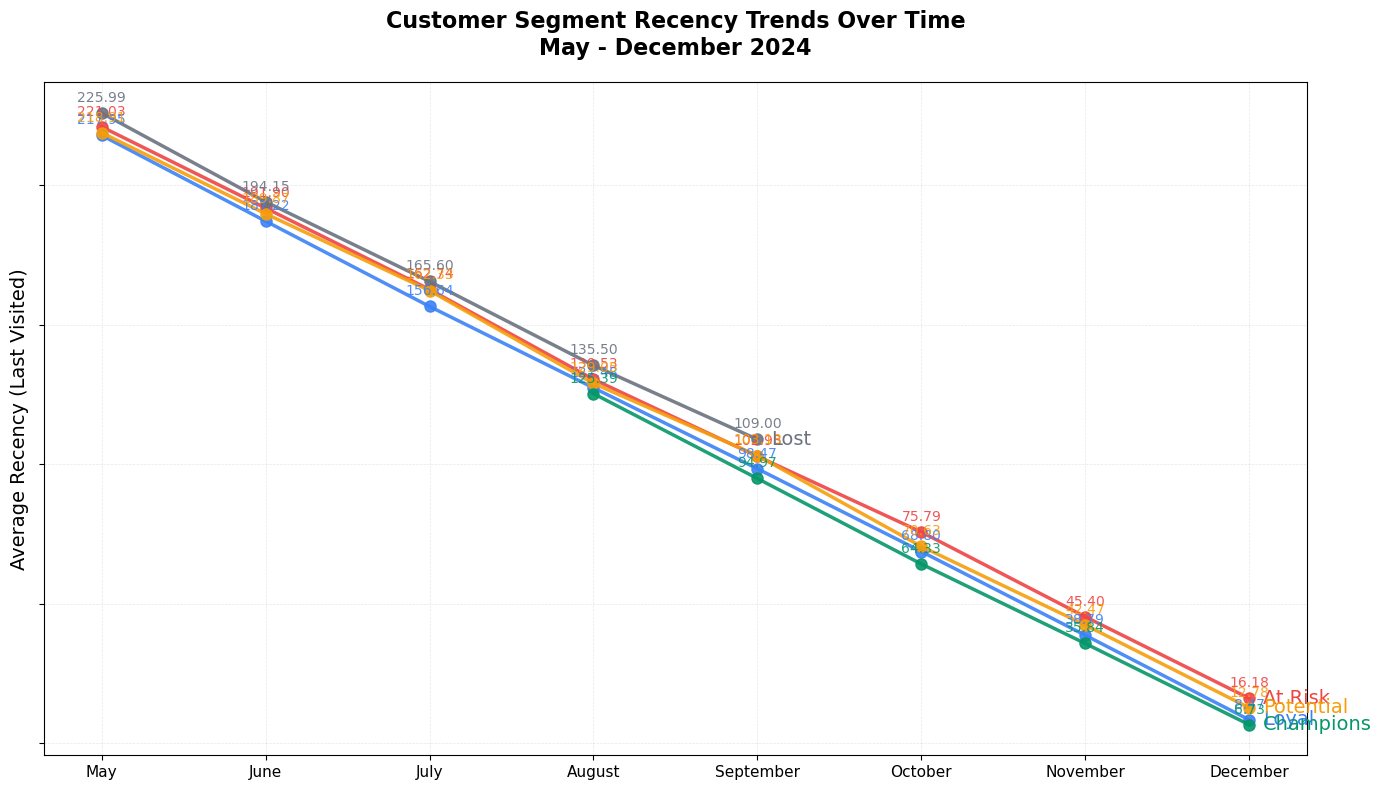

In [93]:
## Monthly Recency Analysis
# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define color palette for segments
colors = {
    'Champions': '#059669',  # Green
    'Loyal': '#3B82F6',      # Blue
    'Potential': '#F59E0B',  # Orange
    'At Risk': '#EF4444',    # Red
    'Lost': '#6B7280'        # Gray
}

# Plot each segment
for segment in segment_summary_month['Segment'].unique():
    segment_data = segment_summary_month[segment_summary_month['Segment'] == segment].sort_values('Month')
    
    ax.plot(segment_data['Month_Name'], 
            segment_data['Avg_Recency'], 
            marker='o', 
            linewidth=2.5,
            markersize=8,
            color=colors.get(segment, '#000000'),
            alpha=0.9)
    
    # Add data labels on each point
    for _, row in segment_data.iterrows():
        ax.annotate(f"{row['Avg_Recency']:.2f}", 
                   xy=(row['Month_Name'], row['Avg_Recency']),
                   xytext=(0, 8), 
                   textcoords='offset points',
                   ha='center',
                   fontsize=10,
                   fontweight='normal',
                   color=colors.get(segment, '#000000'),
                   alpha=0.9)

# Customize the plot
ax.set_xlabel('')
ax.set_ylabel('Average Recency (Last Visited)', fontsize=14, fontweight='normal')
ax.set_title('Customer Segment Recency Trends Over Time\nMay - December 2024', 
             fontsize=16, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Remove y-axis tick labels
ax.set_yticklabels([])

# Set x-axis to show unique month names only
unique_months = segment_summary_month['Month_Name'].unique()
ax.set_xticks(range(len(unique_months)))
ax.set_xticklabels(unique_months, rotation=0)

# Add segment labels on the lines (at the end of each line)
for segment in segment_summary_month['Segment'].unique():
    segment_data = segment_summary_month[segment_summary_month['Segment'] == segment].sort_values('Month')
    if len(segment_data) > 0:
        last_point = segment_data.iloc[-1]
        ax.annotate(segment, 
                   xy=(last_point['Month_Name'], last_point['Avg_Recency']),
                   xytext=(10, 0), 
                   textcoords='offset points',
                   fontsize=14,
                   fontweight='normal',
                   color=colors.get(segment, '#000000'),
                   va='center')

plt.tight_layout()

plt.show()


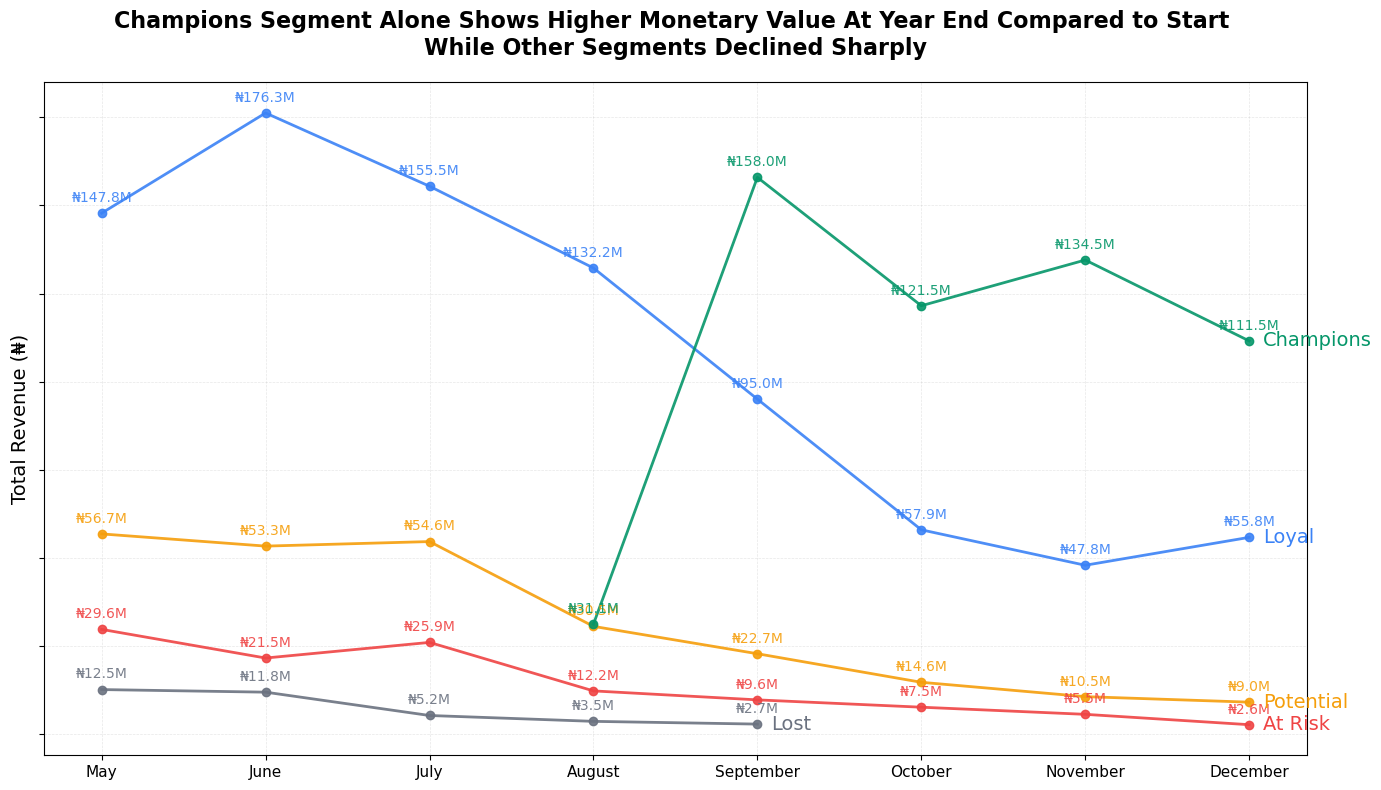

In [94]:

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define color palette for segments
colors = {
    'Champions': '#059669',  # Green
    'Loyal': '#3B82F6',      # Blue
    'Potential': '#F59E0B',  # Orange
    'At Risk': '#EF4444',    # Red
    'Lost': '#6B7280'        # Gray
}

# Function to format revenue in millions
def format_millions(value):
    """Format revenue as millions with 1 decimal place"""
    return f"₦{value/1_000_000:.1f}M"

# Plot each segment
for segment in segment_summary_month['Segment'].unique():
    segment_data = segment_summary_month[segment_summary_month['Segment'] == segment].sort_values('Month')
    
    ax.plot(segment_data['Month_Name'], 
            segment_data['Total_Revenue'], 
            marker='o', 
            linewidth=2,
            markersize=6,
            color=colors.get(segment, '#000000'),
            alpha=0.9)
    
    # Add data labels on each point (formatted in millions)
    for _, row in segment_data.iterrows():
        ax.annotate(format_millions(row['Total_Revenue']), 
                   xy=(row['Month_Name'], row['Total_Revenue']),
                   xytext=(0, 8), 
                   textcoords='offset points',
                   ha='center',
                   fontsize=10,
                   fontweight='normal',
                   color=colors.get(segment, '#000000'),
                   alpha=0.9)

# Customize the plot
ax.set_xlabel('')
ax.set_ylabel('Total Revenue (₦)', fontsize=14, fontweight='normal')
ax.set_title('Champions Segment Alone Shows Higher Monetary Value At Year End Compared to Start \nWhile Other Segments Declined Sharply', 
             fontsize=16, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Remove y-axis tick labels
ax.set_yticklabels([])

# Set x-axis to show unique month names only
unique_months = segment_summary_month['Month_Name'].unique()
ax.set_xticks(range(len(unique_months)))
ax.set_xticklabels(unique_months, rotation=0)

# NO LEGEND (removed)

# Add segment labels on the lines (at the end of each line)
for segment in segment_summary_month['Segment'].unique():
    segment_data = segment_summary_month[segment_summary_month['Segment'] == segment].sort_values('Month')
    if len(segment_data) > 0:
        last_point = segment_data.iloc[-1]
        ax.annotate(segment, 
                   xy=(last_point['Month_Name'], last_point['Total_Revenue']),
                   xytext=(10, 0), 
                   textcoords='offset points',
                   fontsize=14,
                   fontweight='normal',
                   color=colors.get(segment, '#000000'),
                   va='center')

plt.tight_layout()

plt.show()
